## EXPLORATORY DATA ANALYSIS

### 1. Setup and Data Loading

In [39]:
# Import necessary libraries for data analysis and visualization.
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
import seaborn as sns
from pathlib import Path
import warnings

# Spatial analysis libraries.
from libpysal.weights import KNN, Queen
from esda.moran import Moran, Moran_Local
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Suppress warnings for cleaner output.
warnings.filterwarnings("ignore")

# Set visualization parameters.
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

# Set random seed for reproducibility.
np.random.seed(42)

# Font paths.
aleo_path = "data/fonts/Aleo/Aleo-VariableFont_wght.ttf"

# Register fonts.
fm.fontManager.addfont(aleo_path)

# Create FontProperties objects.
font_aleo = fm.FontProperties(fname = aleo_path)

# Global fonts.
plt.rcParams["font.family"] = font_aleo.get_name()
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["font.size"] = 12

In [40]:
# Load model data and spatial boundaries.
data_path = "data/model/Final_Data_Model.csv"
boundaries_path = "data/nyc_city_boundary_land_only/nyc_city_boundary_land_only.shp"
tracts_path = "data/nyc_tracts_2020/nyc_tracts_2020.shp"

# Read CSV data.
df = pd.read_csv(data_path)
print(f"Dataset shape: {df.shape}")
print(f"Total census tracts: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

# Read spatial data.
boundaries = gpd.read_file(boundaries_path)
tracts = gpd.read_file(tracts_path)
tracts = tracts.rename(columns = {"geoid" : "GEOID"})

boundaries = boundaries.to_crs(tracts.crs)

print(f"\nTracts shapefile loaded: {tracts.shape[0]} geometries")
print(f"CRS: {tracts.crs}")

Dataset shape: (2225, 20)
Total census tracts: 2225
Total features: 20

Tracts shapefile loaded: 2325 geometries
CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]


In [41]:
# Merge data with spatial boundaries for mapping.
# Convert GEOID to string for consistent merging.
df["GEOID"] = df["GEOID"].astype(str)
tracts["GEOID"] = tracts["GEOID"].astype(str)

# Perform left join to keep all spatial geometries.
gdf = tracts.merge(df, on = "GEOID", how = "left")
print(f"\nMerged GeoDataFrame shape: {gdf.shape}")
print(f"Tracts with data: {gdf["TOTAL_POP_x"].notna().sum()}")
print(f"Tracts without data: {gdf["TOTAL_POP_x"].isna().sum()}")


Merged GeoDataFrame shape: (2325, 33)
Tracts with data: 2225
Tracts without data: 100


### 2. Data Overview and Summary Statistics

In [42]:
# Display basic dataset information.
print("DATASET INFORMATION")

print(f"\nTotal Observations: {len(df)}")
print(f"Total Features: {len(df.columns)}")
print(f"\nColumn Names:")

# Number them.
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

DATASET INFORMATION

Total Observations: 2225
Total Features: 20

Column Names:
 1. GEOID
 2. TOTAL_POP_x
 3. heatweek_avg_qol_calls
 4. normalweek_avg_qol_calls
 5. heatweek_calls_per_1k
 6. normalweek_calls_per_1k
 7. PCT_BACHELORS_PLUS
 8. PCT_RENTERS
 9. PCT_LIMITED_ENGLISH
10. MEDIAN_INCOME
11. POVERTY_RATE
12. PCT_NON_WHITE
13. PCT_TREE_CANOPY
14. PCT_IMPERVIOUS
15. WCR
16. NDVI
17. BD
18. AH
19. POI_500M_DENSITY
20. KNN_SUBWAY_dist_mean


In [43]:
# Examine data types and missing values.
print("DATA TYPES AND MISSING VALUES\n")

info_df = pd.DataFrame({
    "Data Type": df.dtypes,
    "Non-Null Count": df.count(),
    "Null Count": df.isnull().sum(),
    "Null Percentage": (df.isnull().sum() / len(df) * 100).round(2)
})

print(info_df.to_string())

# Highlight columns with missing values.
missing_cols = info_df[info_df["Null Count"] > 0]

if len(missing_cols) > 0:
    print("\nColumns with missing values:")
    print(missing_cols[["Null Count", "Null Percentage"]].to_string())
else:
    print("\nNo missing values.")

DATA TYPES AND MISSING VALUES

                         Data Type  Non-Null Count  Null Count  Null Percentage
GEOID                       object            2225           0             0.00
TOTAL_POP_x                float64            2225           0             0.00
heatweek_avg_qol_calls     float64            2225           0             0.00
normalweek_avg_qol_calls   float64            2225           0             0.00
heatweek_calls_per_1k      float64            2225           0             0.00
normalweek_calls_per_1k    float64            2225           0             0.00
PCT_BACHELORS_PLUS         float64            2225           0             0.00
PCT_RENTERS                float64            2225           0             0.00
PCT_LIMITED_ENGLISH        float64            2225           0             0.00
MEDIAN_INCOME                int64            2225           0             0.00
POVERTY_RATE               float64            2225           0             0.00
PCT_NON_W

**ANALYSIS: DATA QUALITY AND STRUCTURE**

Dataset has 2,225 census tracts across New York City with 20 features encompassing demographic, environmental, and urban morphology characteristics. The dataset has zero missing values across all variables after collection and processing.

- **Target Variables** (2): Heat week and normal week QoL calls per capita.
- **Call Volume Metrics** (2): Average raw call counts for heat and normal periods.
- **Socioeconomic Predictors** (6): Education, housing tenure, language proficiency, income, poverty, and non-white composition.
- **Environmental Predictors** (4): Tree canopy coverage, impervious surface percentage, water-cover ratio (WCR), and normalized difference vegetation index (NDVI).
- **Urban Form Predictors** (4): Building density (BD), average height (AH), point-of-interest (POI) density, and subway accessibility using kNN.

**Spatial Coverage:**
Merged GeoDataFrame has 2,325 geometries with 2,225 having complete data (i.e. 95.7% coverage), so 100 census tracts don't have enough data for modeling likely due to the tracts not being residential. So these missing tracts might be parks, water bodies, or areas lacking population for the target variables.

In [44]:
# Define predictor categories based on project description.
# Socioeconomic and demographic predictors.
acs_predictors = [
    "PCT_BACHELORS_PLUS",
    "PCT_RENTERS",
    "PCT_LIMITED_ENGLISH",
    "MEDIAN_INCOME",
    "POVERTY_RATE",
    "PCT_NON_WHITE"
]

# Environmental predictors.
env_predictors = [
    "PCT_TREE_CANOPY",
    "PCT_IMPERVIOUS",
    "WCR",
    "NDVI"
]

# Urban form predictors.
urban_predictors = [
    "BD",
    "AH",
    "POI_500M_DENSITY",
    "KNN_SUBWAY_dist_mean"
]

# Combined predictor set with all features.
all_predictors = env_predictors + acs_predictors + urban_predictors

# Target variables.
targets = ["heatweek_calls_per_1k", "normalweek_calls_per_1k"]

# Additional call count variables.
call_vars = ["heatweek_avg_qol_calls", "normalweek_avg_qol_calls"]

print("PREDICTOR CATEGORIES\n")

print(f"Environmental Predictors: {len(env_predictors)}")
print(f"Socioeconomic Predictors: {len(acs_predictors)}")
print(f"Urban Form Predictors: {len(urban_predictors)}")
print(f"Total Predictors: {len(all_predictors)}")
print(f"Target Variables: {len(targets)}")

PREDICTOR CATEGORIES

Environmental Predictors: 4
Socioeconomic Predictors: 6
Urban Form Predictors: 4
Total Predictors: 14
Target Variables: 2


In [46]:
# Make all negative income NaN.
df.loc[df["MEDIAN_INCOME"] < 0, "MEDIAN_INCOME"] = np.nan

In [48]:
# Summary stats for all numeric variables.
print("SUMMARY STATS")

# No scientific notation.
pd.options.display.float_format = "{:,.2f}".format

summary_all = df.describe().T
summary_all["skew"] = df.skew(numeric_only = True)
summary_all["kurtosis"] = df.kurtosis(numeric_only = True)

print(summary_all.to_string())

SUMMARY STATS
                            count      mean       std       min       25%       50%        75%        max  skew  kurtosis
TOTAL_POP_x              2,225.00  3,872.14  1,949.90     57.00  2,469.00  3,551.00   4,939.00  15,945.00  1.14      2.37
heatweek_avg_qol_calls   2,225.00      5.51      8.71      0.00      2.00      3.80       6.60     180.20 10.84    165.19
normalweek_avg_qol_calls 2,225.00      5.99      8.76      0.00      2.43      4.29       7.14     196.71 11.08    180.33
heatweek_calls_per_1k    2,225.00      1.79      4.22      0.00      0.58      1.06       1.89     133.33 17.77    464.69
normalweek_calls_per_1k  2,225.00      1.89      3.66      0.00      0.73      1.19       2.00      97.74 13.52    271.70
PCT_BACHELORS_PLUS       2,225.00      0.38      0.21      0.00      0.22      0.34       0.50       0.94  0.80     -0.10
PCT_RENTERS              2,225.00      0.63      0.25      0.00      0.44      0.66       0.83       1.00 -0.39     -0.87
PCT_LIMITE

In [47]:
# Summary stats by predictor category.
print("SUMMARY STATS - ENVIRONMENTAL PREDICTORS\n")
print(df[env_predictors].describe().T.to_string())

print("\nSUMMARY STATS - SOCIOECONOMIC PREDICTORS\n")
print(df[acs_predictors].describe().T.to_string())

print("\nSUMMARY STATS - URBAN FORM PREDICTORS\n")
print(df[urban_predictors].describe().T.to_string())

print("\nSUMMARY STATS - TARGET VARIABLES\n")
print(df[targets + call_vars].describe().T.to_string())

SUMMARY STATS - ENVIRONMENTAL PREDICTORS

                   count  mean   std  min   25%   50%   75%   max
PCT_TREE_CANOPY 2,225.00  5.65  7.55 0.00  0.84  2.67  8.11 63.86
PCT_IMPERVIOUS  2,225.00 74.52 10.62 9.03 69.59 77.88 81.91 88.06
WCR             2,225.00  0.01  0.03 0.00  0.00  0.00  0.00  0.50
NDVI            2,225.00  0.06  0.03 0.01  0.04  0.06  0.08  0.19

SUMMARY STATS - SOCIOECONOMIC PREDICTORS

                       count      mean       std       min       25%       50%        75%        max
PCT_BACHELORS_PLUS  2,225.00      0.38      0.21      0.00      0.22      0.34       0.50       0.94
PCT_RENTERS         2,225.00      0.63      0.25      0.00      0.44      0.66       0.83       1.00
PCT_LIMITED_ENGLISH 2,225.00      0.01      0.01      0.00      0.00      0.00       0.01       0.16
MEDIAN_INCOME       2,200.00 85,194.36 41,351.66 11,406.00 57,333.25 78,750.00 103,698.25 250,001.00
POVERTY_RATE        2,225.00      0.17      0.12      0.00      0.08      0.13  

**ANALYSIS: SUMMARY STATISTICS AND DISTRIBUTIONAL CHARACTERISTICS**

**Target Variables:**
The mean normalweek_calls_per_1k is slightly higher, challenging the initial hypothesis. This is a counter-intuitive finding that shows the underlying mechanisms is down to *who* complains and *why* rather than the physical environment. Both the target variables have right skewness that signals outlier tracts have disproportionately high call volumes, potentially representing commercial districts or areas with unique sociodemographics or neighborhood characteristics.

**Environmental:**
- **PCT_TREE_CANOPY:** Tree canopy may be a powerful discriminator among neighborhood types as most tracts have very little canopy as opposed to others given the low mean and median yet high maximum.
  
- **NDVI:** Seemingly shows a similar distribution to PCT_TREE_CANOPY.

- **WCR:** Expectedly very low due to the urbanity of NYC unless tracts are bordering water bodies.

- **PCT_IMPERVIOUS:** High percentage is expected due to the built density of metropolitan cities.

**Socioeconomics:**

- **PCT_BACHELORS_PLUS:** Over 30% of individuals attained high education, which also affects awareness and use of city services like 311. Again, high standard deviation indicates unequal distribution of education.

- **PCT_RENTERS:** Expected high values due to NYC being a renter-dominant city. This means a lot of renants may experience infrastructural issues outside of their immediate control, as safety and building regulation responsibilities fall on the landlord.

- **PCT_LIMITED_ENGLISH:** Very high skew shows that individuals who speak limited English are geographically stratified in different parts of NYC. This reflects a significant barrier to accessing 311 services.

- **MEDIAN_INCOME:**: After removing placeholder values, income distribution reveals NYC's stark economic geography. Standard deviation exceeds the mean, indicating bimodal or heavily skewed distribution, which unsurprisingly reflects extreme wealth inequality across census tracts.

- **POVERTY_RATE:** High right skew and a 100% max indicate concentrated poverty in certain neighborhoods.

- **PCT_NON_WHITE:** Racial composition reflects NYC's diversity, but high variability indicates persistent residential segregation patterns that could interact with target variables.

**Urban Form:**
- **BD:** Most tracts have low-to-moderate building coverage with some ultra-dense commercial/residential cores.

- **AH:** Building heights have great skew and range, so there's significant vertical variability in NYC, likely reflecting skyscraper districts in the central core and mid- to low-rise as the geography eases out into the periphery.

- **POI_500M_DENSITY:** Amenities are expectedly highly clustered, likely in denser commercial / business and residential areas.

- **KNN_SUBWAY_dist_mean:** Average walking distance to nearest subway stations shows most tracts generally have reasonable transit access, and this is unsurprising as NYC is the only city in the US with public transport as its main commute / modality for citizens. Although the variation suggests transit deserts exist.

### 3. Univariate Analysis

#### 3.1 Target Variables Distribution

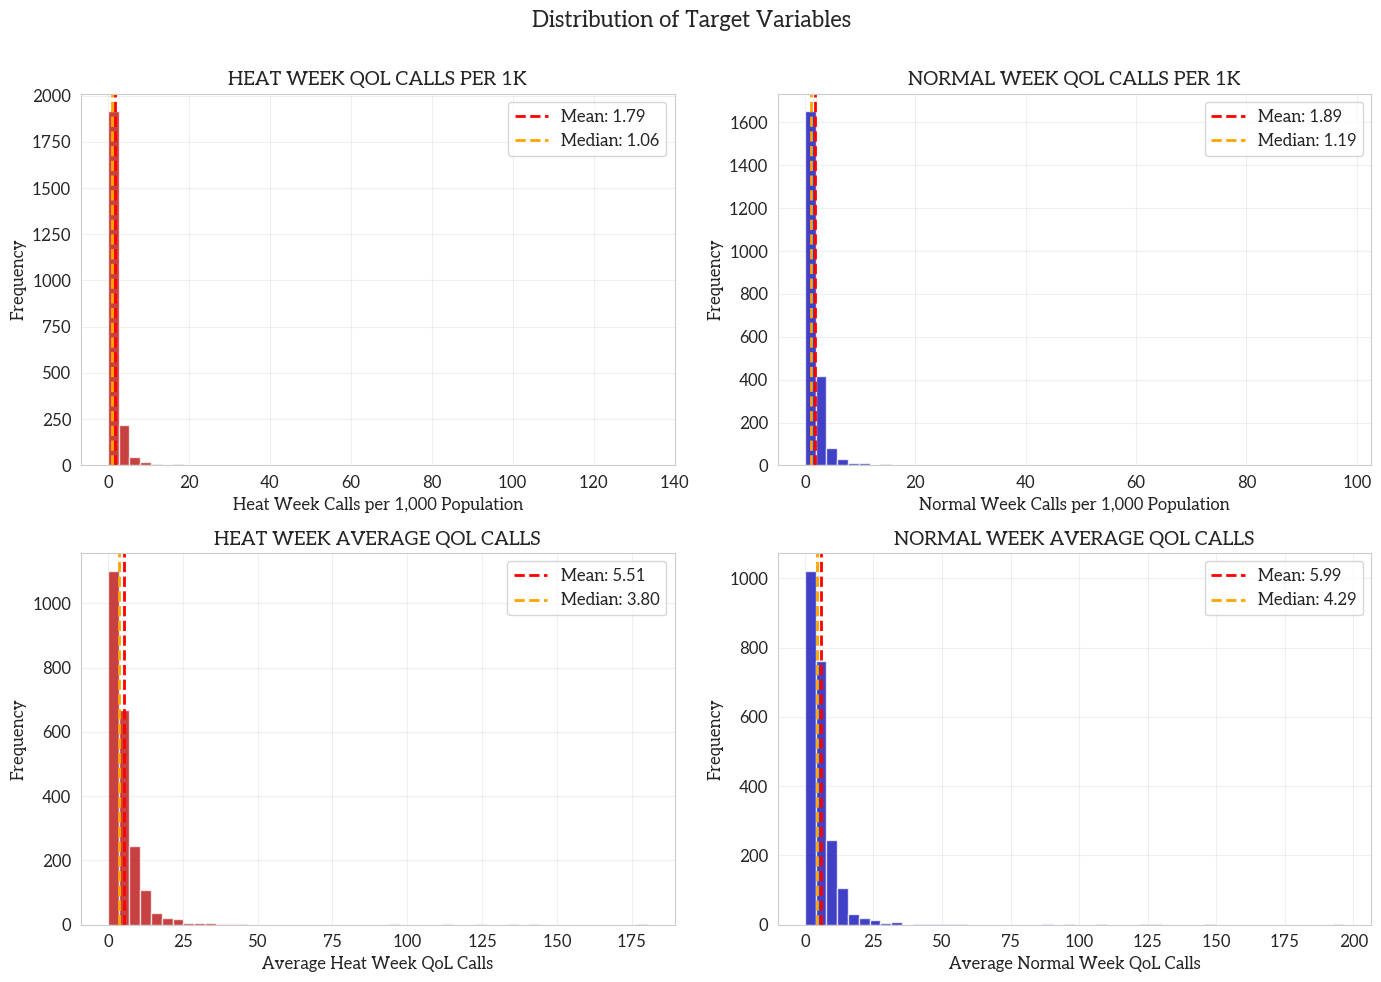

In [9]:
# Distribution viz of target variables with histograms and KDE.
fig, axes = plt.subplots(2, 2, figsize = (14, 10))
fig.suptitle("Distribution of Target Variables\n", fontsize = 16, fontweight = "bold")

# Heat week calls per 1k.
axes[0, 0].hist(df["heatweek_calls_per_1k"], bins = 50,
                edgecolor = "white", alpha = 0.75, color = "#b60101")

axes[0, 0].axvline(df["heatweek_calls_per_1k"].mean(), color = "red", linestyle = "--", linewidth = 2,
                   label = f"Mean: {df['heatweek_calls_per_1k'].mean():.2f}")

axes[0, 0].axvline(df["heatweek_calls_per_1k"].median(), color = "orange", linestyle = "--", linewidth = 2,
                   label = f"Median: {df['heatweek_calls_per_1k'].median():.2f}")

axes[0, 0].set_xlabel("Heat Week Calls per 1,000 Population")

axes[0, 0].set_ylabel("Frequency")

axes[0, 0].set_title("HEAT WEEK QOL CALLS PER 1K")

axes[0, 0].legend()

axes[0, 0].grid(alpha = 0.3)

# Normal week calls per 1k.
axes[0, 1].hist(df["normalweek_calls_per_1k"], bins = 50,
                edgecolor = "white", alpha = 0.75, color = "#0101B6")

axes[0, 1].axvline(df["normalweek_calls_per_1k"].mean(), color = "red", linestyle = "--", linewidth = 2,
                   label = f"Mean: {df['normalweek_calls_per_1k'].mean():.2f}")

axes[0, 1].axvline(df["normalweek_calls_per_1k"].median(), color = "orange", linestyle = "--", linewidth = 2,
                   label = f"Median: {df['normalweek_calls_per_1k'].median():.2f}")

axes[0, 1].set_xlabel("Normal Week Calls per 1,000 Population")

axes[0, 1].set_ylabel("Frequency")

axes[0, 1].set_title("NORMAL WEEK QOL CALLS PER 1K")

axes[0, 1].legend()

axes[0, 1].grid(alpha = 0.3)

# Average QoL calls during heat weeks.
axes[1, 0].hist(df["heatweek_avg_qol_calls"], bins = 50,
                edgecolor = "white", alpha = 0.75, color = "#b60101")

axes[1, 0].axvline(df["heatweek_avg_qol_calls"].mean(), color = "red", linestyle = "--", linewidth = 2,
                   label = f"Mean: {df['heatweek_avg_qol_calls'].mean():.2f}")

axes[1, 0].axvline(df["heatweek_avg_qol_calls"].median(), color = "orange", linestyle = "--", linewidth = 2,
                   label = f"Median: {df['heatweek_avg_qol_calls'].median():.2f}")

axes[1, 0].set_xlabel("Average Heat Week QoL Calls")

axes[1, 0].set_ylabel("Frequency")

axes[1, 0].set_title("HEAT WEEK AVERAGE QOL CALLS")

axes[1, 0].legend()

axes[1, 0].grid(alpha = 0.3)

# Average QoL calls during normal weeks.
axes[1, 1].hist(df["normalweek_avg_qol_calls"], bins = 50,
                edgecolor = "white", alpha = 0.75, color = "#0101B6")

axes[1, 1].axvline(df["normalweek_avg_qol_calls"].mean(), color = "red", linestyle = "--", linewidth = 2,
                   label = f"Mean: {df['normalweek_avg_qol_calls'].mean():.2f}")

axes[1, 1].axvline(df["normalweek_avg_qol_calls"].median(), color = "orange", linestyle = "--", linewidth = 2,
                   label = f"Median: {df['normalweek_avg_qol_calls'].median():.2f}")

axes[1, 1].set_xlabel("Average Normal Week QoL Calls")

axes[1, 1].set_ylabel("Frequency")

axes[1, 1].set_title("NORMAL WEEK AVERAGE QOL CALLS")

axes[1, 1].legend()

axes[1, 1].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

In [51]:
# Boolean where heat week rate is greater than normal week rate.
# Identify tracts with spike in QoL calls during extreme heat.
heat_sensitive = (df["heatweek_calls_per_1k"] > df["normalweek_calls_per_1k"])

count_heat_sensitive_tracts = heat_sensitive.sum()

print(f"Number of tracts with higher QoL calls during extreme heat weeks: {count_heat_sensitive_tracts}")

Number of tracts with higher QoL calls during extreme heat weeks: 852


**ANALYSIS: TARGET VARIABLE DISTRIBUTIONS - HEAT VS NORMAL WEEK QOL CALLS**

Histograms reveal leftward shift in heat week call distribution relative to normal weeks, evidenced by both mean and median decreases. This is a slight call reduction during extreme heat periods, conflicting with the main hypothesis. This may likely be due to behavioral shifts during extremes versus normals. While the 311 calls were selected based on their connections to heat and heightened aggravation with high temperatures, certain complaints like "banging" or "loud music" *could* decrease because individuals may want to insulate themselves indoors with AC, reducing audible and visible perceptions to outdoor or even sanitation issues.

Both distributions have pronounced positive skewness with long right tails extending beyond 15 calls per 1,000 population. However, heat week distribution per capita has more extreme outliers and higher variability, suggesting certain tracts experience disproportionate surges in QoL complaints during heat waves (about 852 tracts, or 38.3% of tracts have higher calls during heat weeks). These outlier tracts warrant individual investigation as they may be commercial districts with transient populations inflating per-capita rates, neighborhoods with vulnerable populations, areas with heightened civic engagement and 311 awareness, or tracts with potential data quality issues.

The great overlap between distributions suggests most tracts maintain relatively stable complaint rates regardless of heat conditions. However, some tracts do show meaningful elevation during heat weeks, highlighting importance of identifying characteristics that predict heat sensitivity rather than assuming universal heat response.

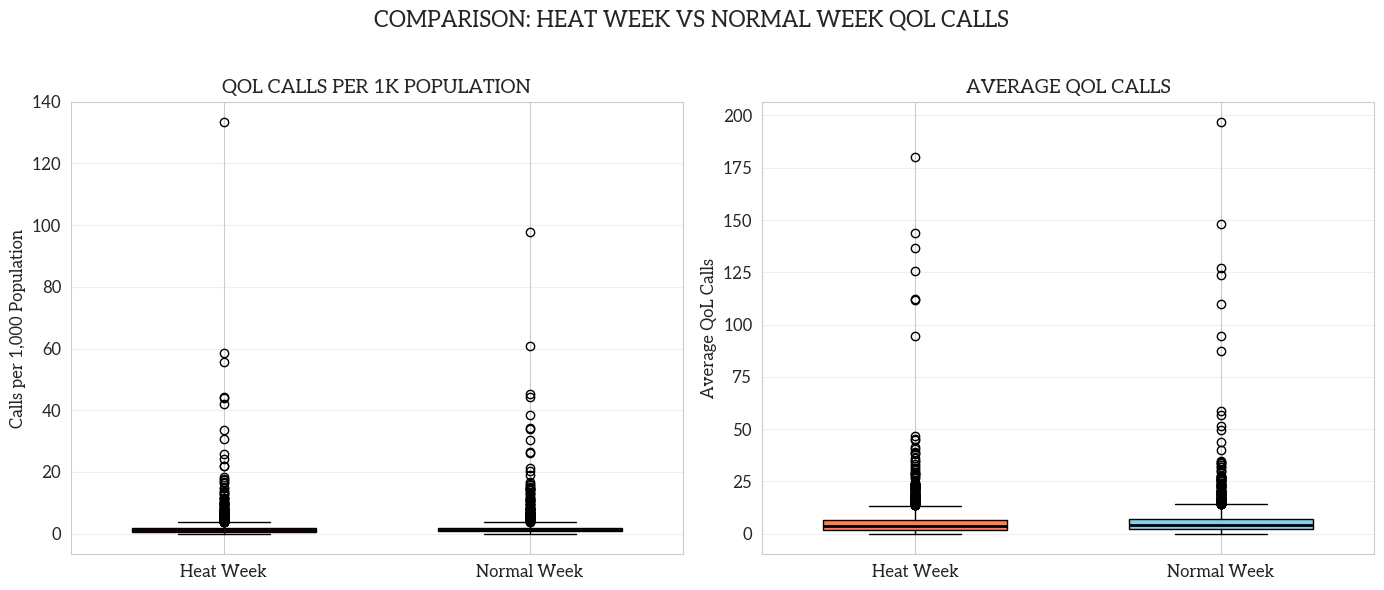

In [10]:
# Boxplot comparison of heat vs normal week calls.
fig, axes = plt.subplots(1, 2, figsize = (14, 6))
fig.suptitle("COMPARISON: HEAT WEEK VS NORMAL WEEK QOL CALLS\n", fontsize = 16, fontweight = "bold")

# Calls per 1k comparison.
box_data_1 = [df["heatweek_calls_per_1k"].dropna(), df["normalweek_calls_per_1k"].dropna()]

bp1 = axes[0].boxplot(box_data_1, labels = ["Heat Week", "Normal Week"], patch_artist = True, widths = 0.6)

bp1["boxes"][0].set_facecolor("orangered")

bp1["boxes"][1].set_facecolor("steelblue")

for median in bp1["medians"]:
    median.set_color("black")
    median.set_linewidth(2)

axes[0].set_ylabel("Calls per 1,000 Population")

axes[0].set_title("QOL CALLS PER 1K POPULATION")

axes[0].grid(alpha = 0.3, axis = "y")

# Average calls comparison.
box_data_2 = [df["heatweek_avg_qol_calls"].dropna(), df["normalweek_avg_qol_calls"].dropna()]

bp2 = axes[1].boxplot(box_data_2, labels = ["Heat Week", "Normal Week"], patch_artist = True, widths = 0.6)

bp2["boxes"][0].set_facecolor("coral")

bp2["boxes"][1].set_facecolor("skyblue")

for median in bp2["medians"]:
    median.set_color("black")
    median.set_linewidth(2)

axes[1].set_ylabel("Average QoL Calls")

axes[1].set_title("AVERAGE QOL CALLS")

axes[1].grid(alpha = 0.3, axis = "y")

plt.tight_layout()
plt.show()

**ANALYSIS: HEAT WEEK VS NORMAL WEEK COMPARISON - BOXPLOT DIAGNOSTICS**

Average call count boxplots show similar heat-elevation pattern but with less pronounced differences compared to per-capita rates. This divergence shows that population normalization reveals heat effects that absolute call counts might obscure, so smaller tracts may show dramatic per-capita changes despite slight absolute increases.

Heat week per capita distribution exhibits more numerous and more extreme outliers compared to normal weeks. This particular pattern does reinforce one of the hypotheses that certain neighborhood social and physical configurations create extreme heat sensitivity.

#### 3.2 Environmental Predictors

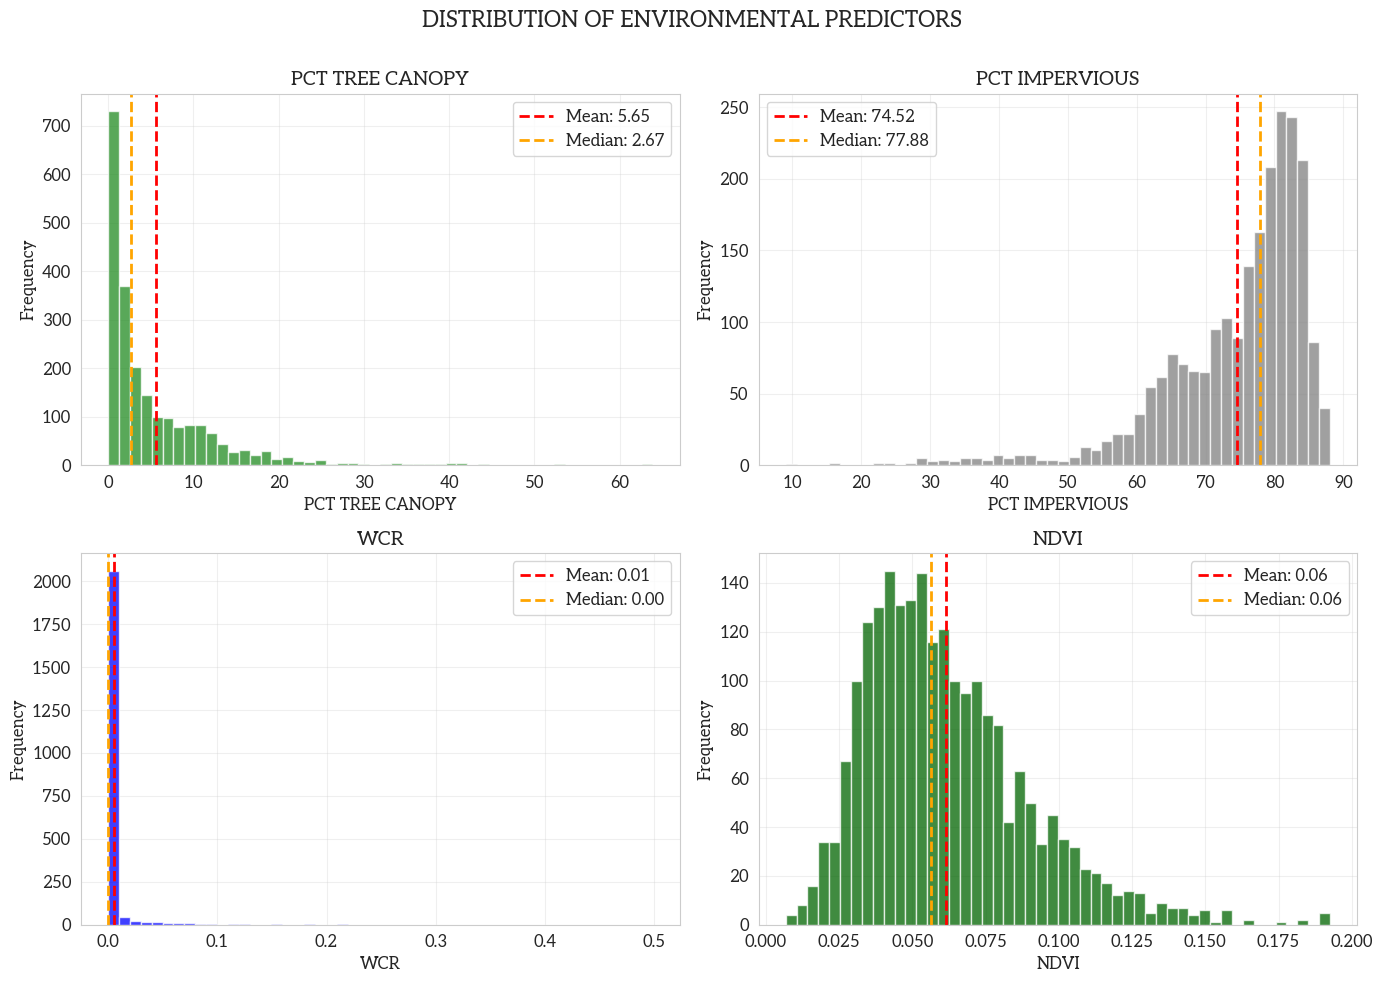

In [11]:
# Distribution viz of environmental predictors.
fig, axes = plt.subplots(2, 2, figsize = (14, 10))
fig.suptitle("DISTRIBUTION OF ENVIRONMENTAL PREDICTORS\n", fontsize = 16, fontweight = "bold")

colors = ["forestgreen", "gray", "blue", "darkgreen"]

for idx, (var, color) in enumerate(zip(env_predictors, colors)):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].hist(df[var].dropna(), bins = 50,
                        edgecolor = "white", alpha = 0.75, color = color)
    
    axes[row, col].axvline(df[var].mean(), color = "red", linestyle = "--", linewidth = 2,
                           label = f"Mean: {df[var].mean():.2f}")
    
    axes[row, col].axvline(df[var].median(), color = "orange", linestyle = "--", linewidth = 2,
                           label = f"Median: {df[var].median():.2f}")
    
    axes[row, col].set_xlabel(var.replace("_", " ").upper())
    
    axes[row, col].set_ylabel("Frequency")

    axes[row, col].set_title(var.replace("_", " ").upper())

    axes[row, col].legend()

    axes[row, col].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

#### 3.3 Socioeconomic Predictors

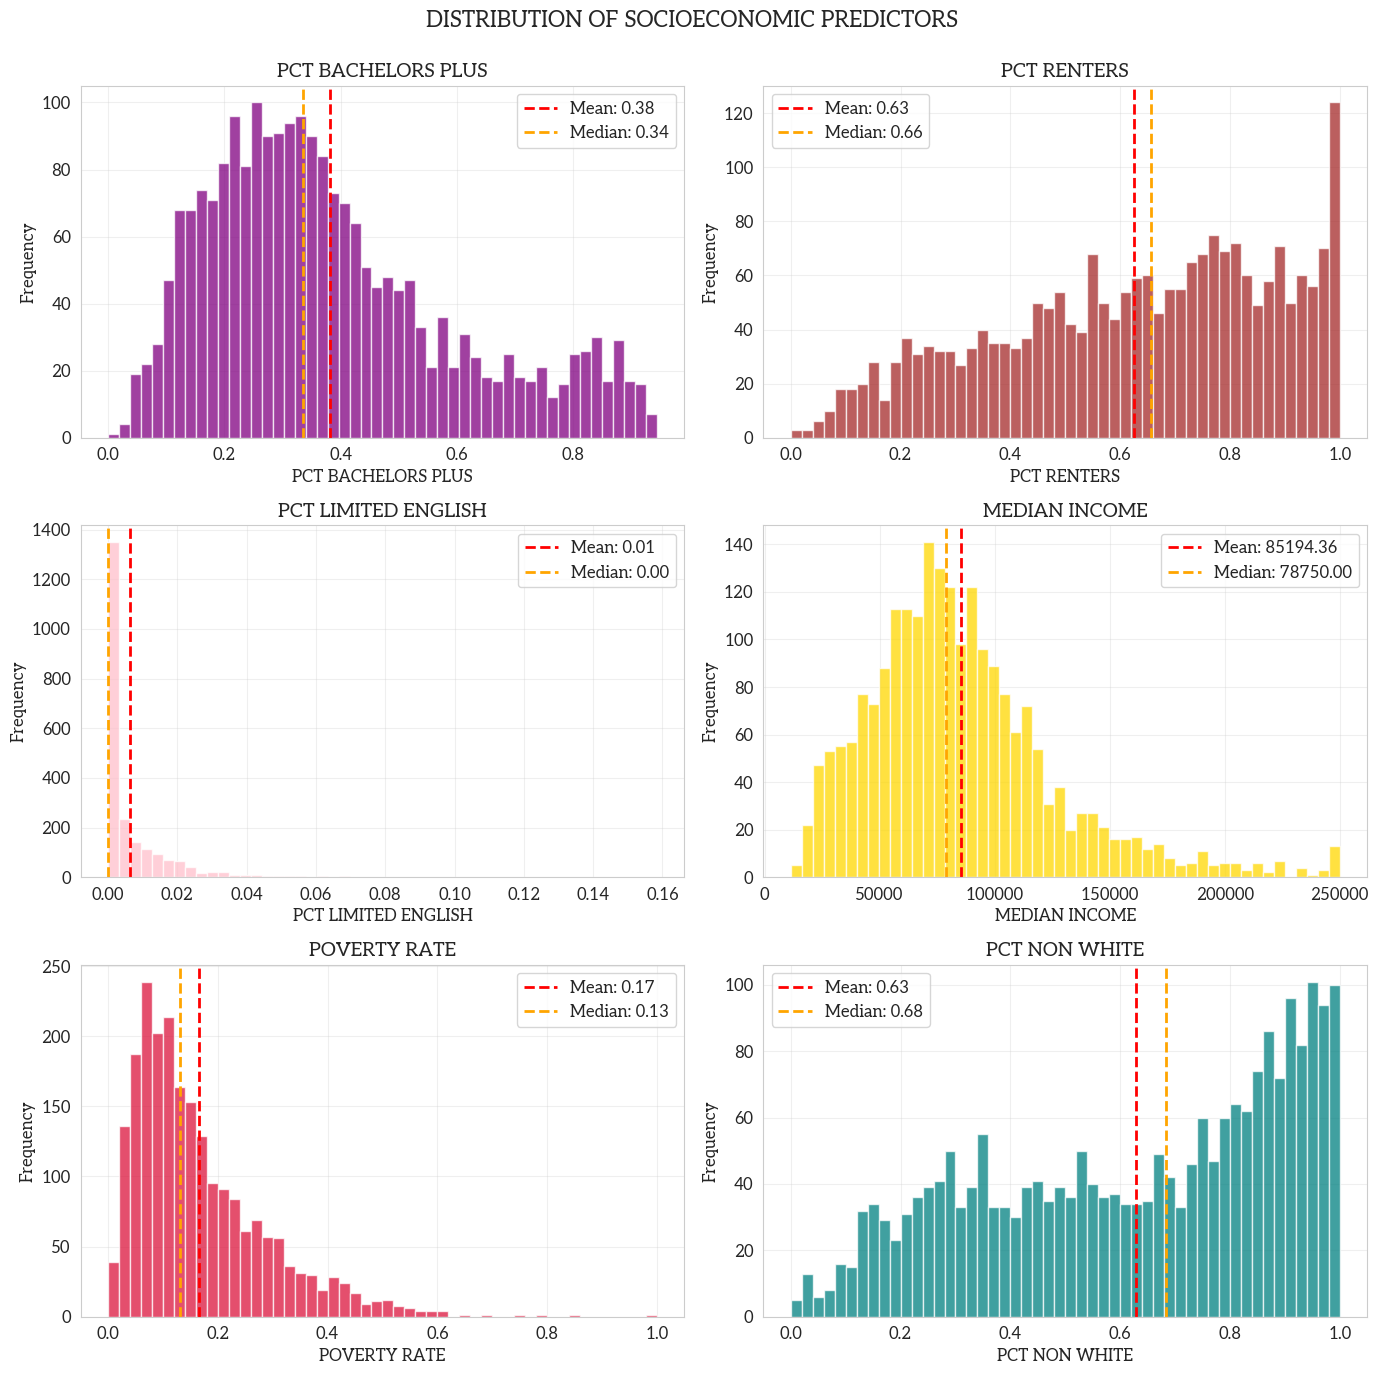

In [12]:
# Distribution viz of socioeconomic predictors.
fig, axes = plt.subplots(3, 2, figsize = (14, 14))
fig.suptitle("DISTRIBUTION OF SOCIOECONOMIC PREDICTORS\n", fontsize = 16, fontweight = "bold")

colors = ["purple", "brown", "pink", "gold", "crimson", "teal"]

for idx, (var, color) in enumerate(zip(acs_predictors, colors)):
    row = idx // 2
    col = idx % 2
    
    # Handle special case for MEDIAN_INCOME which may have placeholder values.
    data = df[var].copy()
    
    if var == "MEDIAN_INCOME":
        data = data[data > 0]  # Filter out negative placeholder values.
    
    axes[row, col].hist(data.dropna(), bins = 50,
                        edgecolor = "white", alpha = 0.75, color = color)
    
    axes[row, col].axvline(data.mean(), color = "red", linestyle = "--", linewidth = 2,
                           label = f"Mean: {data.mean():.2f}")
    
    axes[row, col].axvline(data.median(), color = "orange", linestyle = "--", linewidth = 2,
                           label = f"Median: {data.median():.2f}")
    
    axes[row, col].set_xlabel(var.replace("_", " ").upper())

    axes[row, col].set_ylabel("Frequency")

    axes[row, col].set_title(var.replace("_", " ").upper())

    axes[row, col].legend()
    
    axes[row, col].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

#### 3.4 Urban Form Predictors

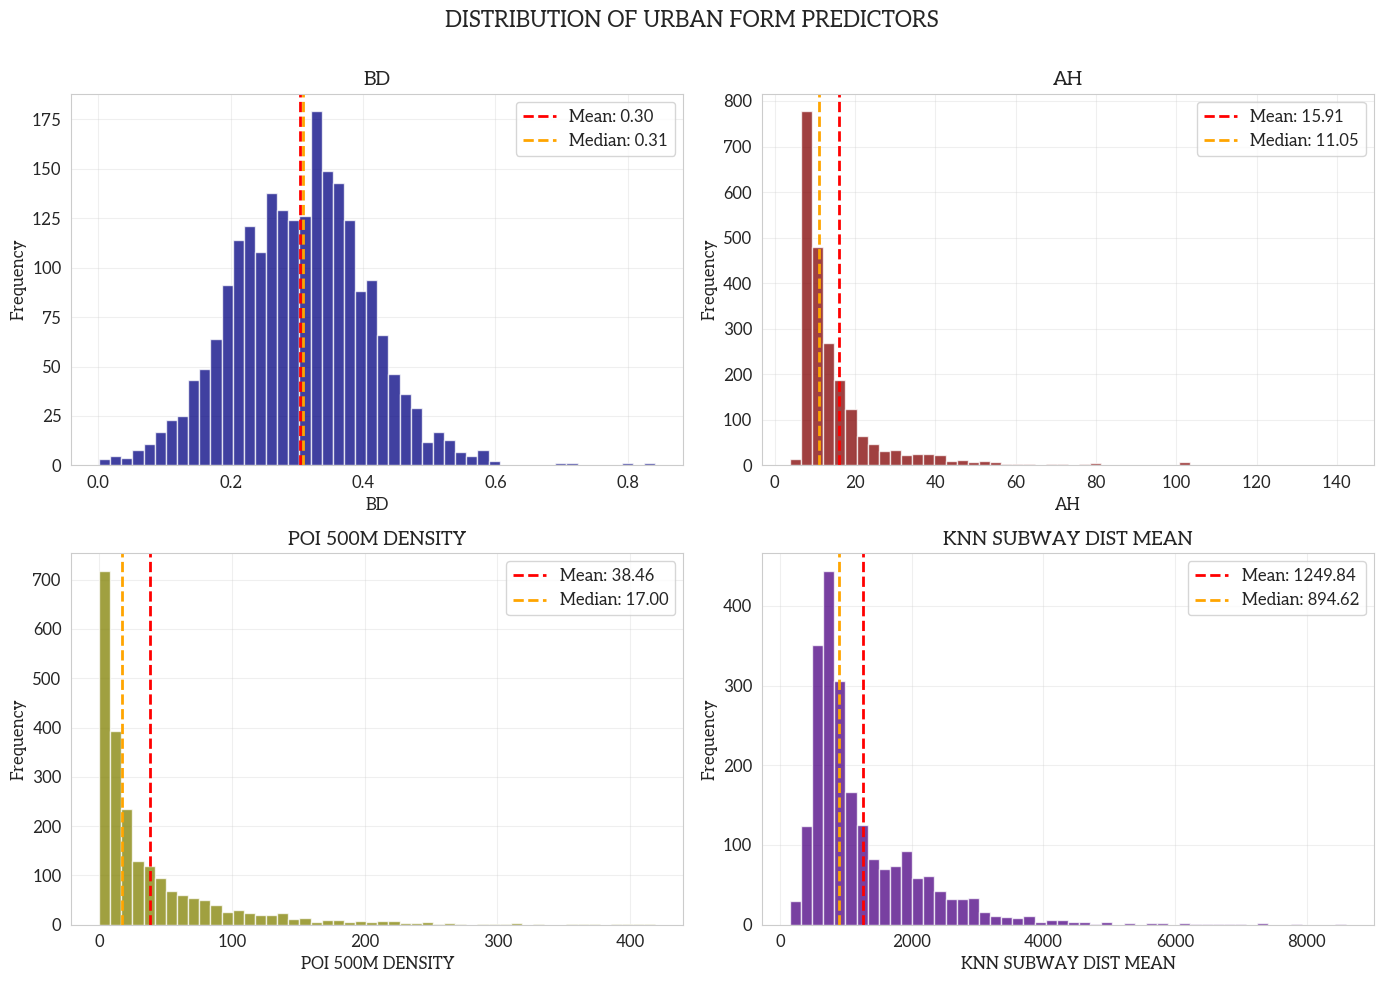

In [13]:
# Distribution viz of urban form predictors.
fig, axes = plt.subplots(2, 2, figsize = (14, 10))
fig.suptitle("DISTRIBUTION OF URBAN FORM PREDICTORS\n", fontsize = 16, fontweight = "bold")

colors = ["navy", "maroon", "olive", "indigo"]

for idx, (var, color) in enumerate(zip(urban_predictors, colors)):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].hist(df[var].dropna(),
                        bins = 50, edgecolor = "white", alpha = 0.75, color = color)
    
    axes[row, col].axvline(df[var].mean(), color = "red", linestyle = "--", linewidth = 2,
                           label = f"Mean: {df[var].mean():.2f}")
    
    axes[row, col].axvline(df[var].median(), color = "orange", linestyle = "--", linewidth = 2,
                           label = f"Median: {df[var].median():.2f}")
    
    axes[row, col].set_xlabel(var.replace("_", " ").upper())

    axes[row, col].set_ylabel("Frequency")

    axes[row, col].set_title(var.replace("_", " ").upper())

    axes[row, col].legend()
    
    axes[row, col].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

### 4. Bivariate Analysis

#### 4.1 Correlation Analysis

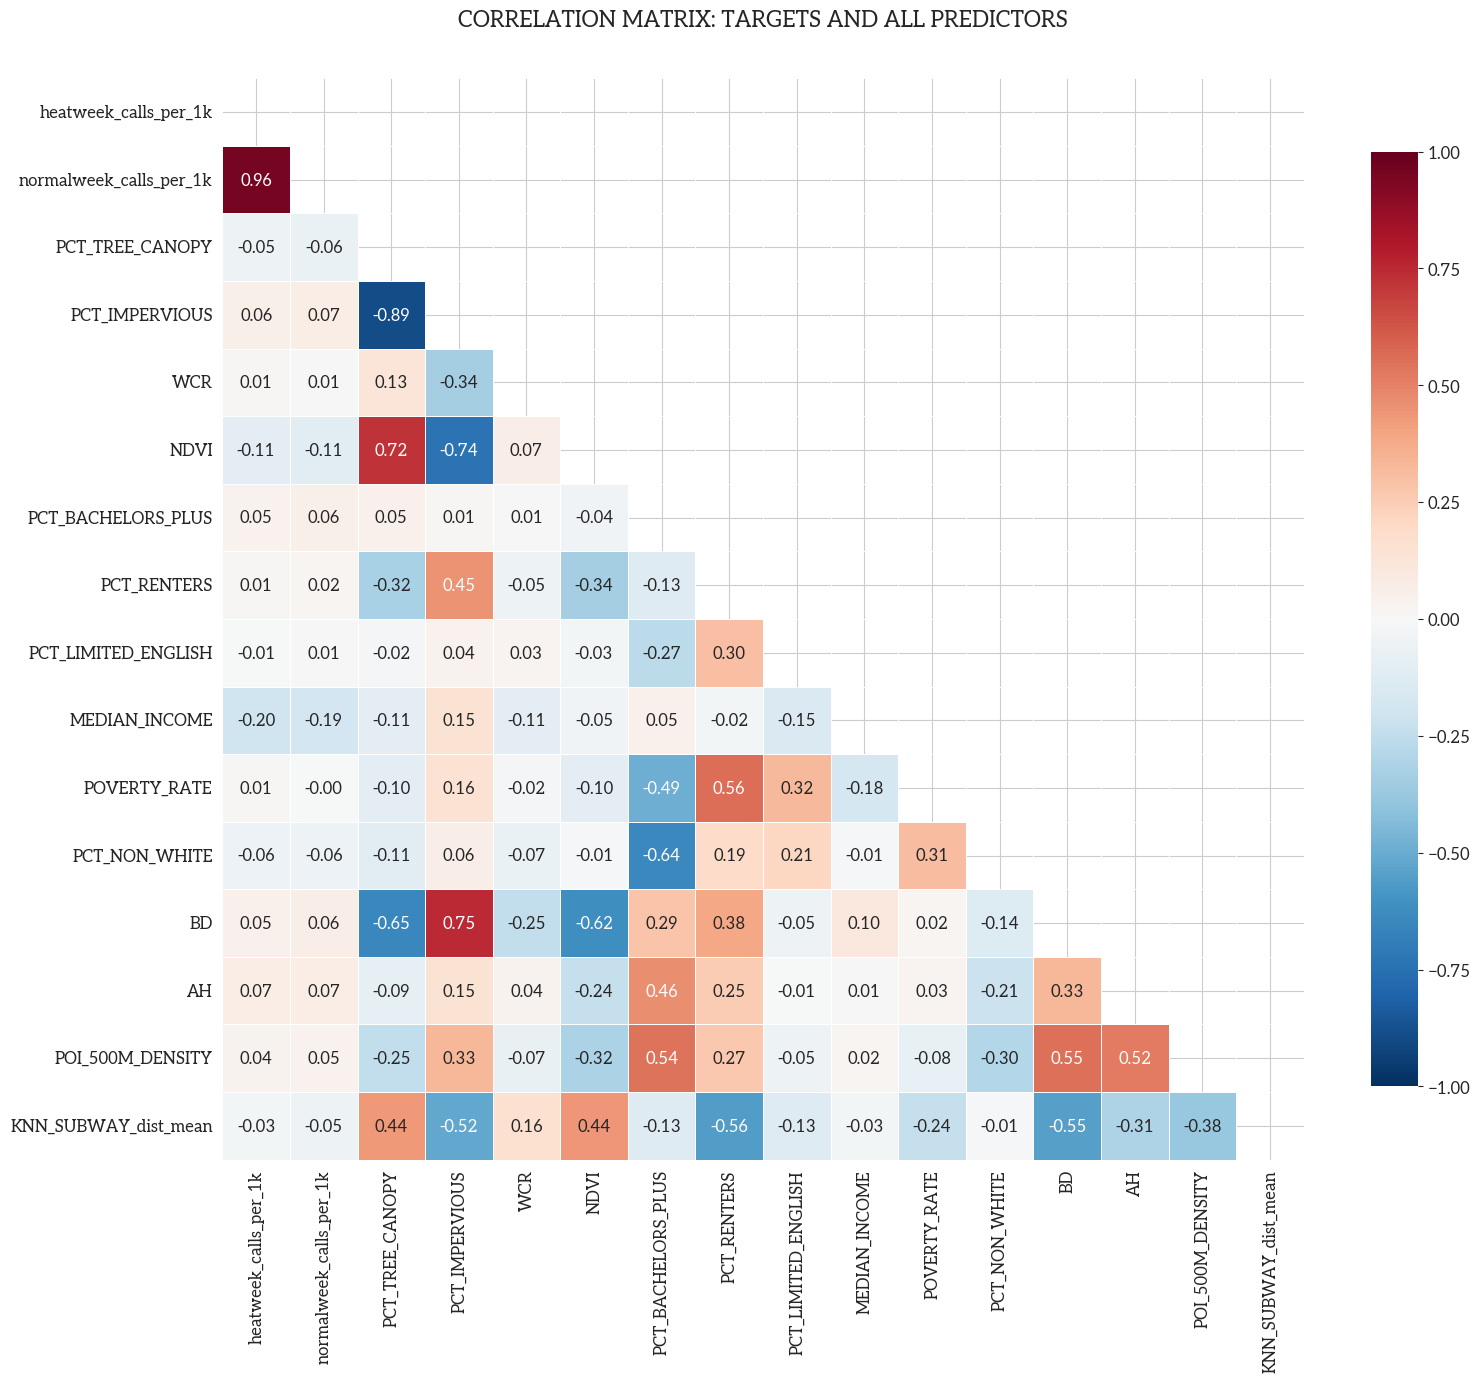

In [14]:
# Correlation matrix for all predictors and targets.
analysis_vars = targets + all_predictors
corr_matrix = df[analysis_vars].corr()

# Correlation matrix viz with heatmap.
fig, ax = plt.subplots(figsize = (16, 14))

mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

sns.heatmap(corr_matrix, mask = mask, annot = True, fmt = ".2f", cmap = "RdBu_r", 
            center = 0, vmin = -1, vmax = 1, square = True, linewidths = 0.5,
            cbar_kws = {"shrink": 0.8}, ax = ax)

ax.set_title("CORRELATION MATRIX: TARGETS AND ALL PREDICTORS\n", fontsize = 16, fontweight = "bold", pad = 20)

plt.tight_layout()
plt.show()

CORRELATIONS WITH TARGET VARIABLES

                      Heat Week Calls  Normal Week Calls  Difference
MEDIAN_INCOME               -0.198402          -0.185367   -0.013035
NDVI                        -0.105720          -0.113270    0.007550
AH                           0.072747           0.072362    0.000385
PCT_IMPERVIOUS               0.059164           0.073177   -0.014013
PCT_NON_WHITE               -0.058319          -0.061150    0.002831
PCT_TREE_CANOPY             -0.054636          -0.063440    0.008804
BD                           0.048339           0.063436   -0.015096
PCT_BACHELORS_PLUS           0.045007           0.058821   -0.013814
POI_500M_DENSITY             0.035472           0.045540   -0.010068
KNN_SUBWAY_dist_mean        -0.028824          -0.048551    0.019727
PCT_RENTERS                  0.014312           0.020747   -0.006435
WCR                          0.014266           0.007046    0.007219
POVERTY_RATE                 0.014119          -0.001531    0.01565

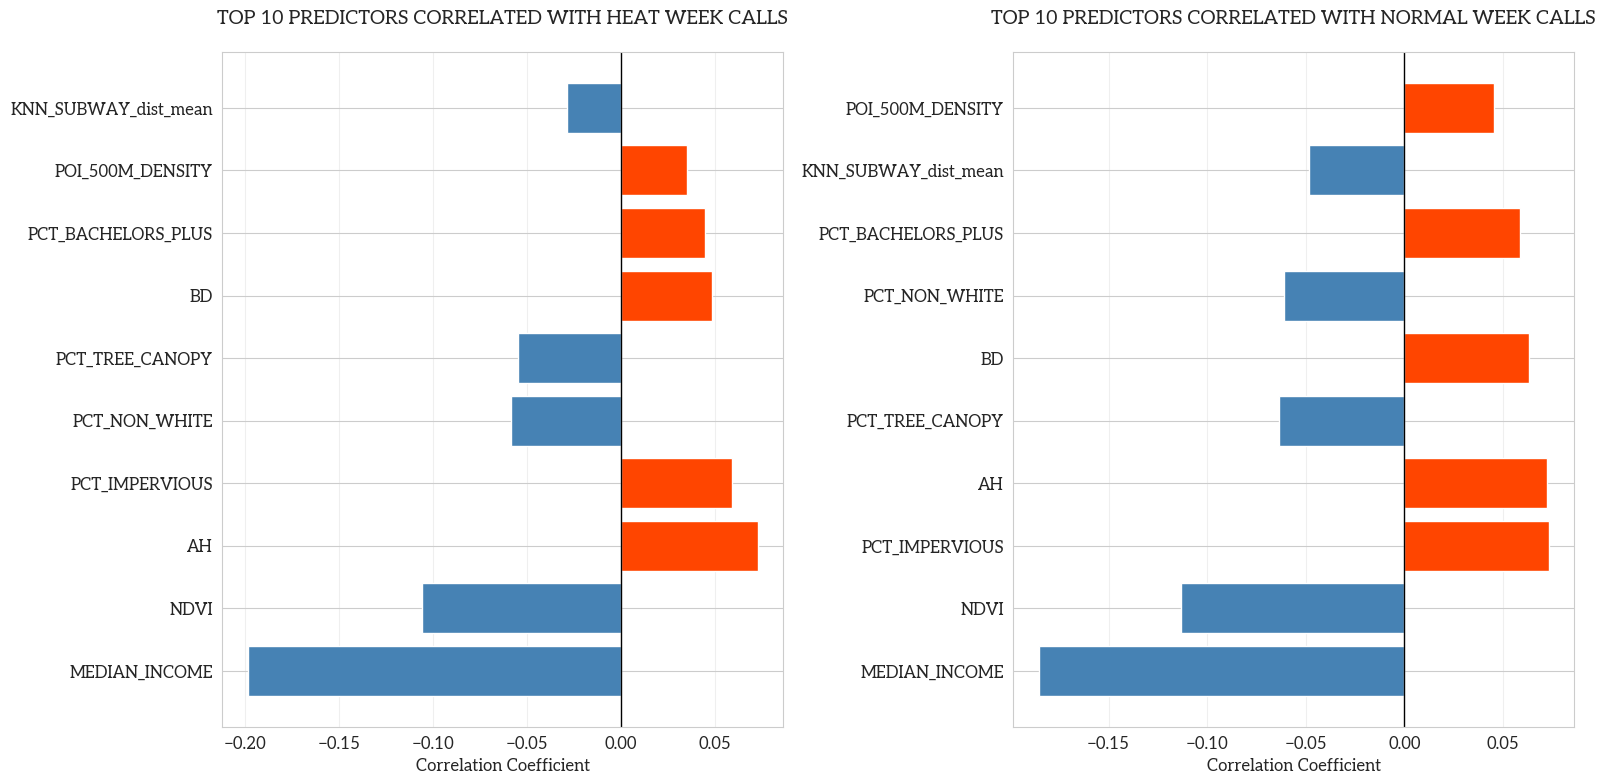

In [15]:
# Correlation of predictors with target variables.
print("CORRELATIONS WITH TARGET VARIABLES\n")

target_corrs = pd.DataFrame({
    "Heat Week Calls": corr_matrix["heatweek_calls_per_1k"][all_predictors],
    "Normal Week Calls": corr_matrix["normalweek_calls_per_1k"][all_predictors]
})

target_corrs["Difference"] = target_corrs["Heat Week Calls"] - target_corrs["Normal Week Calls"]

target_corrs = target_corrs.sort_values("Heat Week Calls", key = abs, ascending = False)

print(target_corrs.to_string())

# Visualize top correlations with targets.
fig, axes = plt.subplots(1, 2, figsize = (16, 8))

# Heat week correlations.
top_n = 10
top_heat = target_corrs["Heat Week Calls"].sort_values(key = abs, ascending = False).head(top_n)
colors_heat = ["orangered" if x > 0 else "steelblue" for x in top_heat.values]

axes[0].barh(range(len(top_heat)), top_heat.values,
             color = colors_heat, edgecolor = "white")

axes[0].set_yticks(range(len(top_heat)))

axes[0].set_yticklabels(top_heat.index)

axes[0].set_xlabel("Correlation Coefficient")

axes[0].set_title(f"TOP {top_n} PREDICTORS CORRELATED WITH HEAT WEEK CALLS\n", fontweight = "bold")

axes[0].axvline(0, color = "black", linewidth = 1)

axes[0].grid(alpha = 0.3, axis = "x")

# Normal week correlations.
top_normal = target_corrs["Normal Week Calls"].sort_values(key = abs, ascending = False).head(top_n)
colors_normal = ["orangered" if x > 0 else "steelblue" for x in top_normal.values]

axes[1].barh(range(len(top_normal)), top_normal.values,
             color = colors_normal, edgecolor = "white")

axes[1].set_yticks(range(len(top_normal)))

axes[1].set_yticklabels(top_normal.index)

axes[1].set_xlabel("Correlation Coefficient")

axes[1].set_title(f"TOP {top_n} PREDICTORS CORRELATED WITH NORMAL WEEK CALLS\n", fontweight = "bold")

axes[1].axvline(0, color = "black", linewidth = 1)

axes[1].grid(alpha = 0.3, axis = "x")

plt.tight_layout()
plt.show()

**ANALYSIS: CORRELATION STRUCTURE AND PREDICTOR RELATIONSHIPS**

Heat week and normal week call rates show strong positive correlation, indicating neighborhoods with high baseline complaint rates also show elevated rates during heat periods. Again, imperfect correlation suggests heat amplifies complaints differently, with some tracts having proportionally larger increases than baseline activity.

**Tree Canopy and NDVI Correlation:** Tree canopy coverage and NDVI measure related environmental characteristics. But it also suggests that they both capture unique aspects, especially since NDVI reflects all vegetation including grass / shrubs while tree canopy specifically quantifies woody vegetation providing shade.

**Impervious Surface Relationships:** Negative correlations show expected trade-off between built environment and green space. But there are some tracts with high vegetation despite substantial impervious coverage, potentially through street trees, small parks, or green infrastructure.

**Income and Education Correlation:** Strong positive association between higher education and median income is expected.

**Income and Poverty Correlation:** Extremely strong negative correlation creates redundancy as these variables measure opposite ends of same economic spectrum.

**Race and Poverty Correlation:** Moderate positive correlation between percent non-white and poverty rate reflects persistent structural racism and residential segregation in NYC.

**Building Density and Height Correlation:** Moderate positive correlation suggests taller buildings tend to cluster in denser areas.

**POI Density and Subway Access Correlation:** Negative correlation indicates that commercial centers concentrate near transit. However, stats indicate deserts with commercial activity and transit-rich residential zones both exist.

**Green Space and Heat Calls Correlation:** Weak negative correlations support the hypothesis on buffering effects, though relationships are weaker than anticipated. However, this may require nonlinear modeling or interaction terms to capture threshold effects.

**Income and Heat Calls Correlation:** Near-zero or weakly positive correlation challenges simple vulnerability narrative, supporting one of the hypotheses of nuanced prediction that affluent areas may show increased reporting despite lower physiological vulnerability.

#### 4.2 Scatterplots: Key Relationships

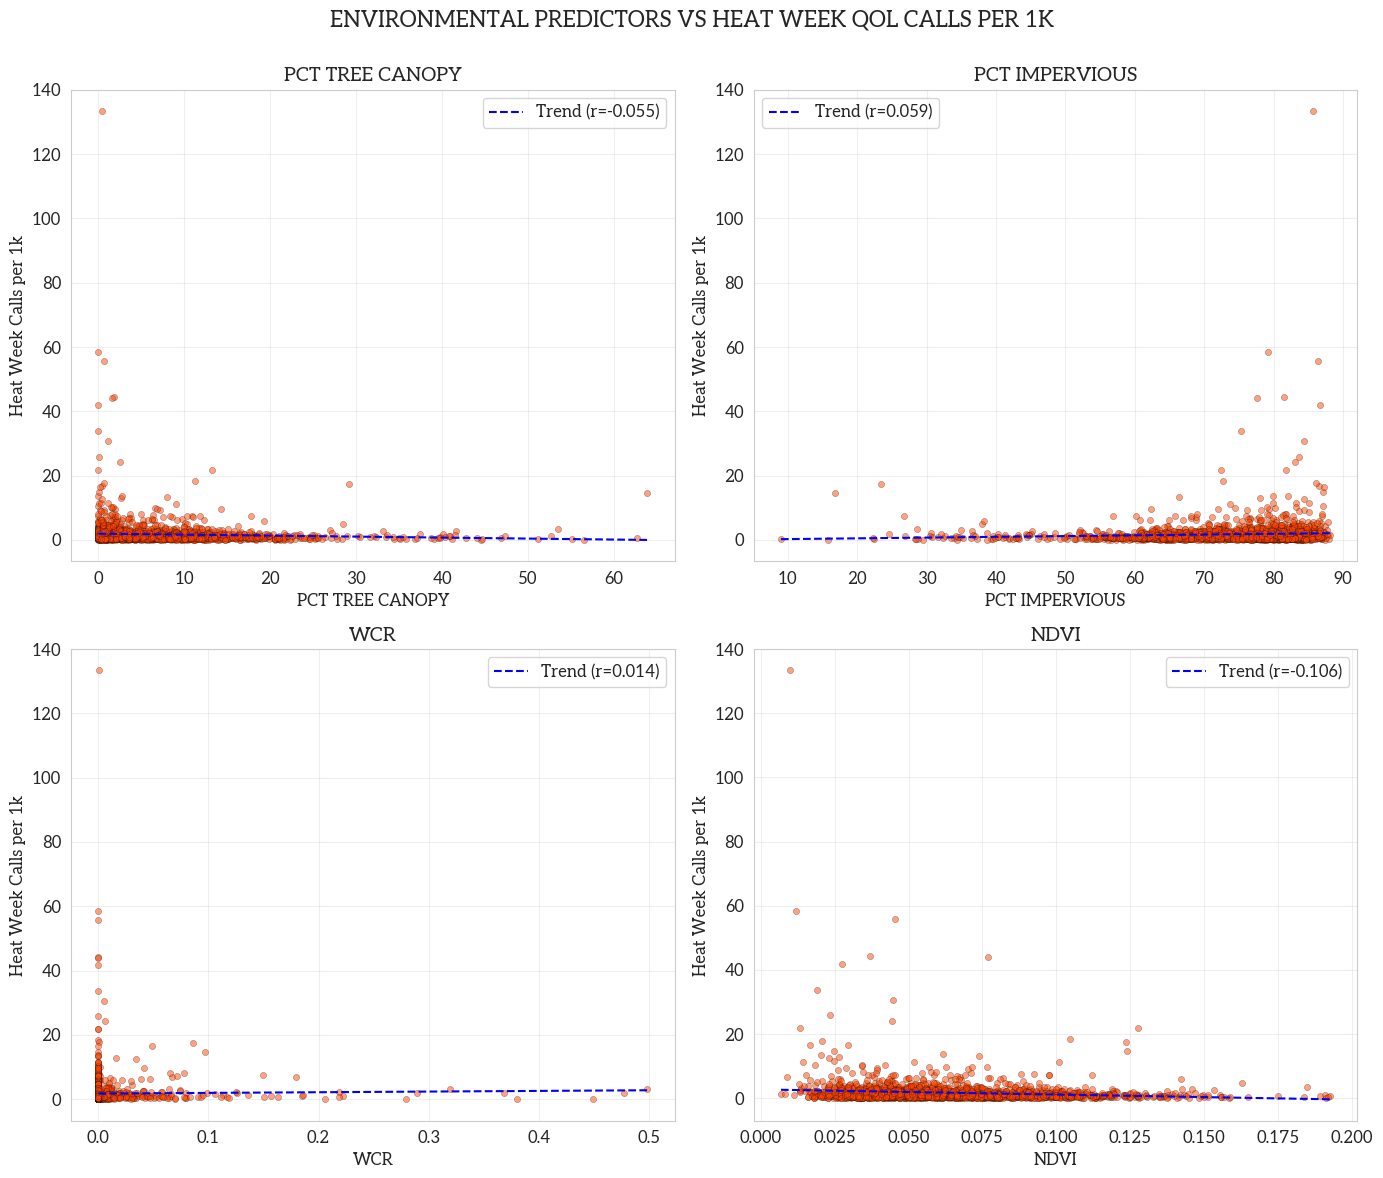

In [16]:
# Scatterplots of environmental predictors vs heat week calls.
fig, axes = plt.subplots(2, 2, figsize = (14, 12))
fig.suptitle("ENVIRONMENTAL PREDICTORS VS HEAT WEEK QOL CALLS PER 1K\n", fontsize = 16, fontweight = "bold")

for idx, var in enumerate(env_predictors):
    row = idx // 2
    col = idx % 2
    
    axes[row, col].scatter(df[var], df["heatweek_calls_per_1k"], alpha = 0.5, s = 20,
                           color = "orangered", edgecolors = "black", linewidth = 0.3)
    
    # Add regression line.
    valid_mask = df[var].notna() & df["heatweek_calls_per_1k"].notna()

    if valid_mask.sum() > 1:
        z = np.polyfit(df.loc[valid_mask, var], df.loc[valid_mask, "heatweek_calls_per_1k"], 1)
        p = np.poly1d(z)
        x_line = np.linspace(df[var].min(), df[var].max(), 100)
        axes[row, col].plot(x_line, p(x_line), "b--", linewidth = 1.5,
                            label = f"Trend (r={corr_matrix.loc[var, 'heatweek_calls_per_1k']:.3f})")
    
    axes[row, col].set_xlabel(var.replace("_", " ").upper())
    
    axes[row, col].set_ylabel("Heat Week Calls per 1k")

    axes[row, col].set_title(var.replace("_", " ").upper())

    axes[row, col].legend()

    axes[row, col].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

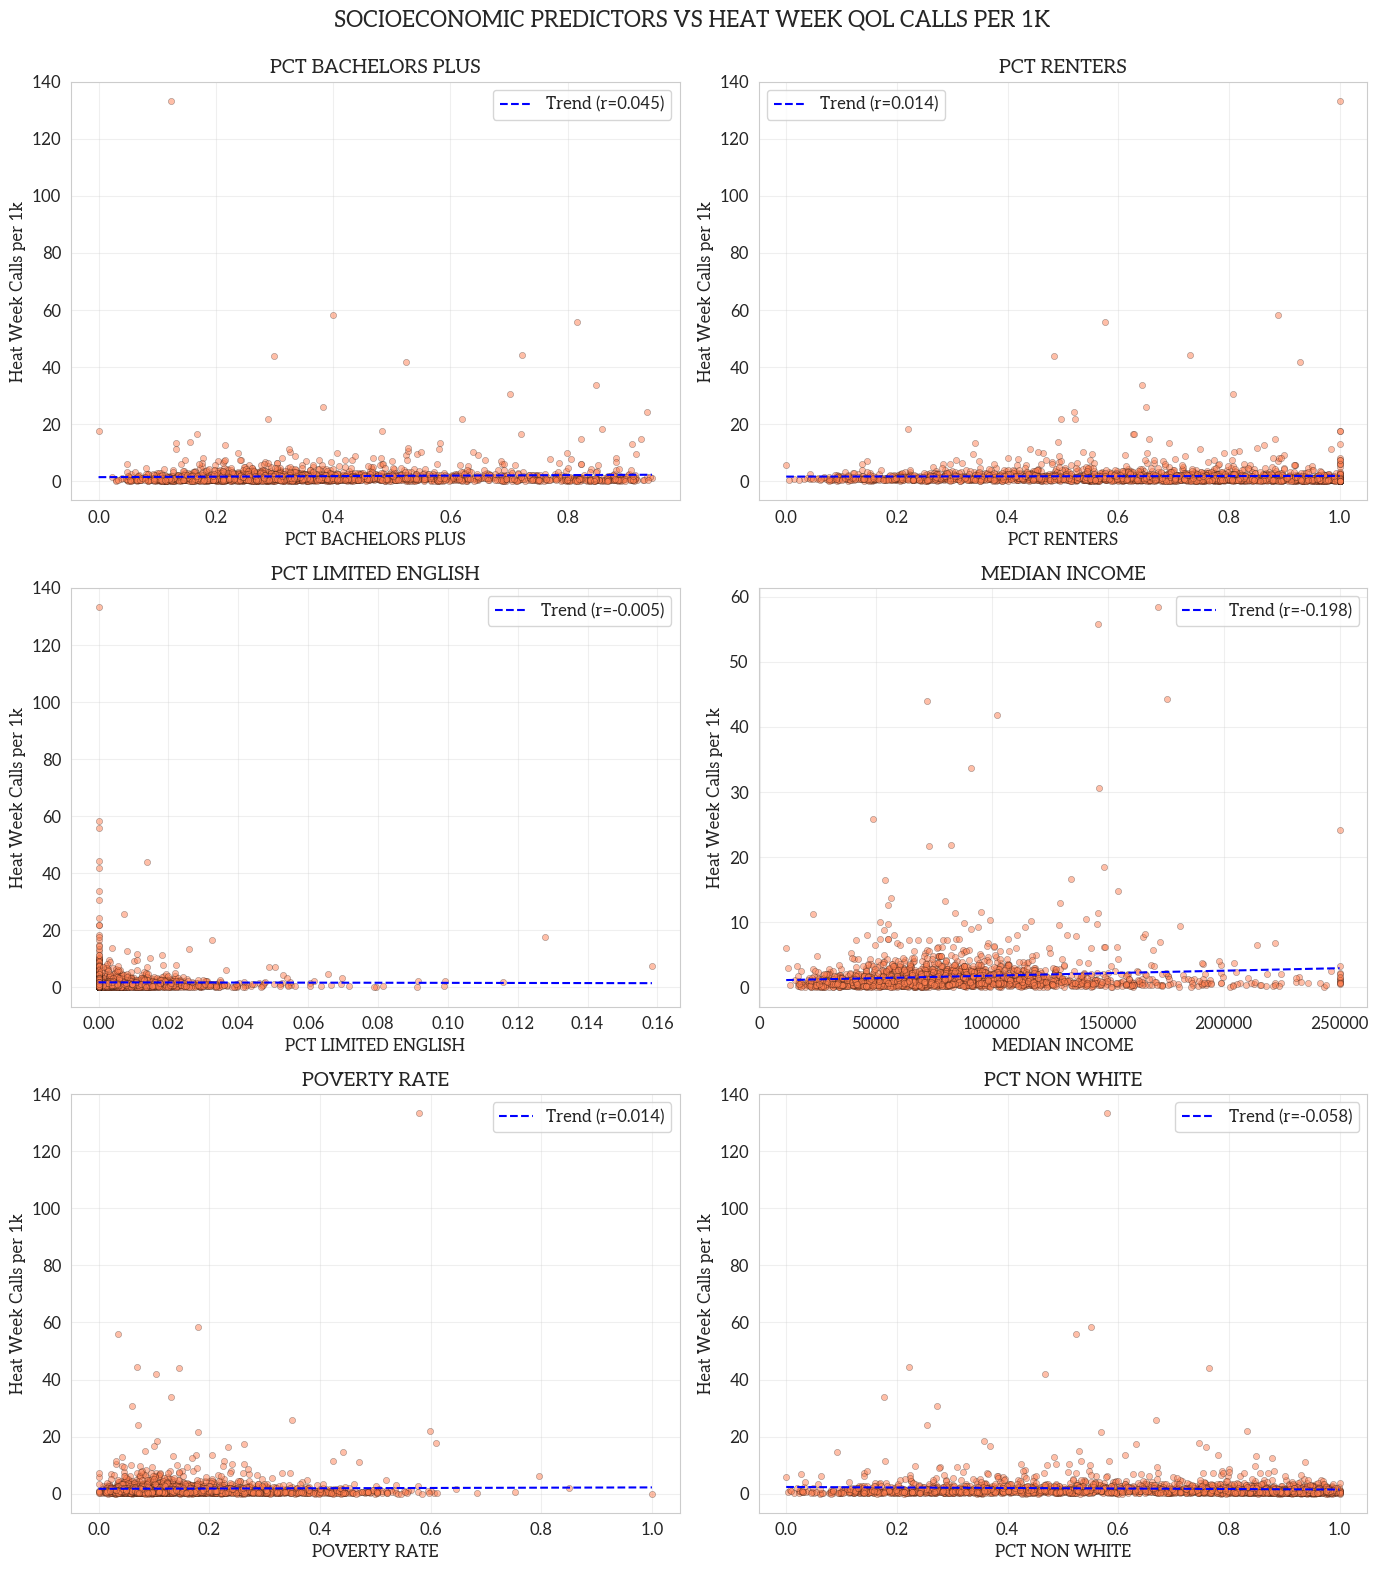

In [17]:
# Scatterplots of socioeconomic predictors vs heat week calls.
fig, axes = plt.subplots(3, 2, figsize = (14, 16))
fig.suptitle("SOCIOECONOMIC PREDICTORS VS HEAT WEEK QOL CALLS PER 1K\n", fontsize = 16, fontweight = "bold")

for idx, var in enumerate(acs_predictors):
    row = idx // 2
    col = idx % 2
    
    # Handle special case for MEDIAN_INCOME.
    if var == "MEDIAN_INCOME":
        plot_data = df[df[var] > 0]
    else:
        plot_data = df
    
    axes[row, col].scatter(plot_data[var], plot_data["heatweek_calls_per_1k"], alpha = 0.5, s = 20,
                           color = "coral", edgecolors = "black", linewidth = 0.3)
    
    # Add regression line.
    valid_mask = plot_data[var].notna() & plot_data["heatweek_calls_per_1k"].notna()
    
    if valid_mask.sum() > 1:
        z = np.polyfit(plot_data.loc[valid_mask, var], plot_data.loc[valid_mask, "heatweek_calls_per_1k"], 1)
        p = np.poly1d(z)
        x_line = np.linspace(plot_data[var].min(), plot_data[var].max(), 100)
        axes[row, col].plot(x_line, p(x_line), "b--", linewidth = 1.5,
                            label = f"Trend (r={corr_matrix.loc[var, 'heatweek_calls_per_1k']:.3f})")
    
    axes[row, col].set_xlabel(var.replace("_", " ").upper())

    axes[row, col].set_ylabel("Heat Week Calls per 1k")

    axes[row, col].set_title(var.replace("_", " ").upper())

    axes[row, col].legend()

    axes[row, col].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

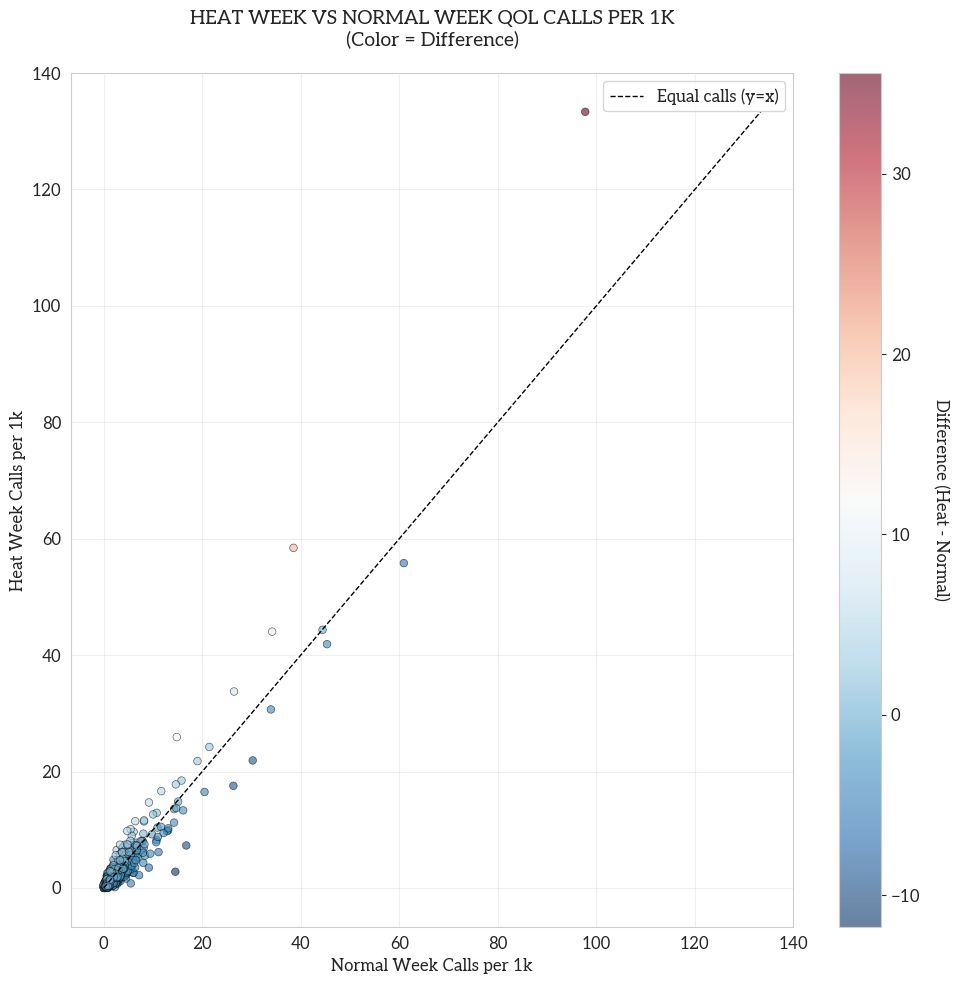

In [18]:
# Direct comparison scatterplot: Heat week vs Normal week calls.
fig, ax = plt.subplots(figsize = (10, 10))

df["calls_per_1k_diff"] = (
    df["heatweek_calls_per_1k"] - df["normalweek_calls_per_1k"]
)

ax.scatter(df["normalweek_calls_per_1k"], df["heatweek_calls_per_1k"], 
           alpha = 0.6, s = 30, c = df["calls_per_1k_diff"], 
           cmap = "RdBu_r", edgecolors = "black", linewidth = 0.5)

# Add diagonal reference line.
max_val = max(df["normalweek_calls_per_1k"].max(), df["heatweek_calls_per_1k"].max())

ax.plot([0, max_val], [0, max_val], "k--", linewidth = 1, label = "Equal calls (y=x)")

ax.set_xlabel("Normal Week Calls per 1k", fontsize = 12)

ax.set_ylabel("Heat Week Calls per 1k", fontsize = 12)

ax.set_title("HEAT WEEK VS NORMAL WEEK QOL CALLS PER 1K\n(Color = Difference)\n",
             fontsize = 14, fontweight = "bold")

ax.legend()

ax.grid(alpha = 0.3)

cbar = plt.colorbar(ax.collections[0], ax = ax)
cbar.set_label("Difference (Heat - Normal)", rotation = 270, labelpad = 20)

plt.tight_layout()
plt.show()

Tracts above diagonal (more calls during heat): 852 (38.3%)

Tracts below diagonal (fewer calls during heat): 1356 (60.9%)

Tracts on diagonal (equal calls): 17 (0.8%)

### 5. Multicollinearity Assessment

In [19]:
# Prepare data for VIF calculation.
# Drop rows with missing values in predictors.
vif_data = df[all_predictors].copy()

# Handle MEDIAN_INCOME placeholder values.
if "MEDIAN_INCOME" in vif_data.columns:
    vif_data.loc[vif_data["MEDIAN_INCOME"] < 0, "MEDIAN_INCOME"] = np.nan

vif_data = vif_data.dropna()

# Calculate VIF for each predictor.
vif_results = pd.DataFrame()
vif_results["Variable"] = all_predictors
vif_results["VIF"] = [variance_inflation_factor(vif_data.values, i) for i in range(len(all_predictors))]
vif_results = vif_results.sort_values("VIF", ascending = False)

# Add warning flags.
vif_results["Flag"] = vif_results["VIF"].apply(lambda x: "HIGH" if x > 10 else ("MODERATE" if x > 5 else "OK"))

print(vif_results.to_string(index = False))

            Variable       VIF     Flag
      PCT_IMPERVIOUS 91.157613     HIGH
                  BD 34.217427     HIGH
         PCT_RENTERS 19.851946     HIGH
       MEDIAN_INCOME 19.329657     HIGH
  PCT_BACHELORS_PLUS 18.848913     HIGH
                NDVI 13.140951     HIGH
       PCT_NON_WHITE 10.648866     HIGH
        POVERTY_RATE  7.065295 MODERATE
KNN_SUBWAY_dist_mean  5.199786 MODERATE
     PCT_TREE_CANOPY  4.991505       OK
                  AH  3.770991       OK
    POI_500M_DENSITY  3.157401       OK
 PCT_LIMITED_ENGLISH  1.591361       OK
                 WCR  1.142325       OK


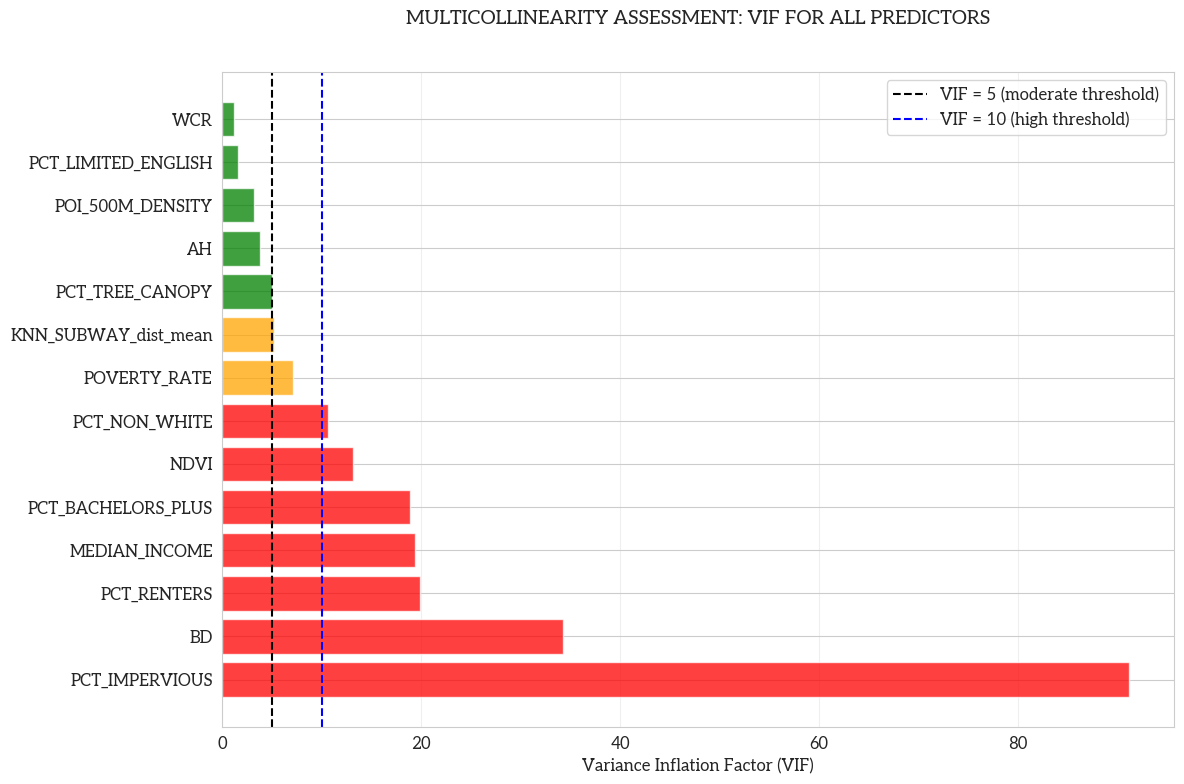

In [20]:
# VIF values viz.
fig, ax = plt.subplots(figsize = (12, 8))

colors = ["red" if x > 10 else "orange" if x > 5 else "green" for x in vif_results["VIF"]]

bars = ax.barh(range(len(vif_results)), vif_results["VIF"], color = colors, edgecolor = "white", alpha = 0.75)

ax.set_yticks(range(len(vif_results)))

ax.set_yticklabels(vif_results["Variable"])

ax.set_xlabel("Variance Inflation Factor (VIF)", fontsize = 12)

ax.set_title("MULTICOLLINEARITY ASSESSMENT: VIF FOR ALL PREDICTORS\n\n",
             fontsize = 14, fontweight = "bold")

ax.axvline(5, color = "black", linestyle = "--", linewidth = 1.5,
           label = "VIF = 5 (moderate threshold)")

ax.axvline(10, color = "blue", linestyle = "--", linewidth = 1.5,
           label = "VIF = 10 (high threshold)")

ax.legend()

ax.grid(alpha = 0.3, axis = "x")

plt.tight_layout()
plt.show()

**ANALYSIS: MULTICOLLINEARITY ASSESSMENT - VARIANCE INFLATION FACTORS**

**Critical VIF Violations (10 < VIF>):**
PCT_RENTERS, BD, and PCT_IMPERVIOUS are likely very correlated with one another as imperviousness and building density have overlapping measures of the physical city, whereas renters as opposed to owners will be concentrated in denser areas.

PCT_BACHELORS_PLUS and MEDIAN_INCOME are expectedly correlated with one another as higher educational attainment often meets that higher earning gradient.

NDVI's high VIF indicates a correlation with its inverse of impervious surface as well as correlation with PCT_TREE_CANOPY. It may have a higher VIF due to its broader measurements that capture more city characteristics than tree canopy.

PCT_NON_WHITE is likely associated with POVERTY_RATE, but the former may capture more broad sociodemographics, hence the higher VIF.

**Moderate Multicollinearity Concerns (5 < VIF < 10):**

POVERTY_RATE and KNN_SUBWAY_dist_mean are moderately multicollinear, the former with MEDIAN_INCOME and PCT_NON_WHITE and the latter with the urban form variables. However, these metrics do not have as drastic of VIF values as their related counterparts.

**Acceptable VIF Range (VIF < 5):**
Low VIF for WCR, PCT_LIMITED_ENGLISH, POI_DENSITY, AH, and PCT_TREE_CANOPY indicate that these are the most distinct and independent variables from 311 QoL reports in heat.

With this, it seems the variables cluster strongly and reveal that socioeconomic and environmental inequality is not composed of independent factors, but rather tightly bundled mechanisms that drive 311 reporting behavior. This means that OLS, while providing an interpretable baseline, is not ideal for capturing all these variables, reinforcing the need for models robust against multicollinearity like Random Forest.

### 6. Spatial Analysis and Visualization

#### 6.1 Choropleth Maps of Key Variables

In [21]:
# Helper function to plot maps.
def plot_map(ax, column, cmap, title, gdf_source, vmin = None, vmax = None):
    gdf_source.plot(
        column = column,
        cmap = cmap,
        legend = True,
        ax = ax,
        linewidth = 0,
        edgecolor = "face",
        antialiased = False,
        rasterized = True,
        missing_kwds = {"color": "lightgrey"},
        vmin = vmin,
        vmax = vmax
    )
    
    boundaries.plot(
        ax = ax,
        facecolor = "none",
        edgecolor = "#9b9e98",
        linewidth = 1
    )

    ax.set_title(
        title,
        fontsize = 20,
        fontproperties = font_aleo,
        fontweight = "bold",
        pad = 12
    )

    ax.axis("off")

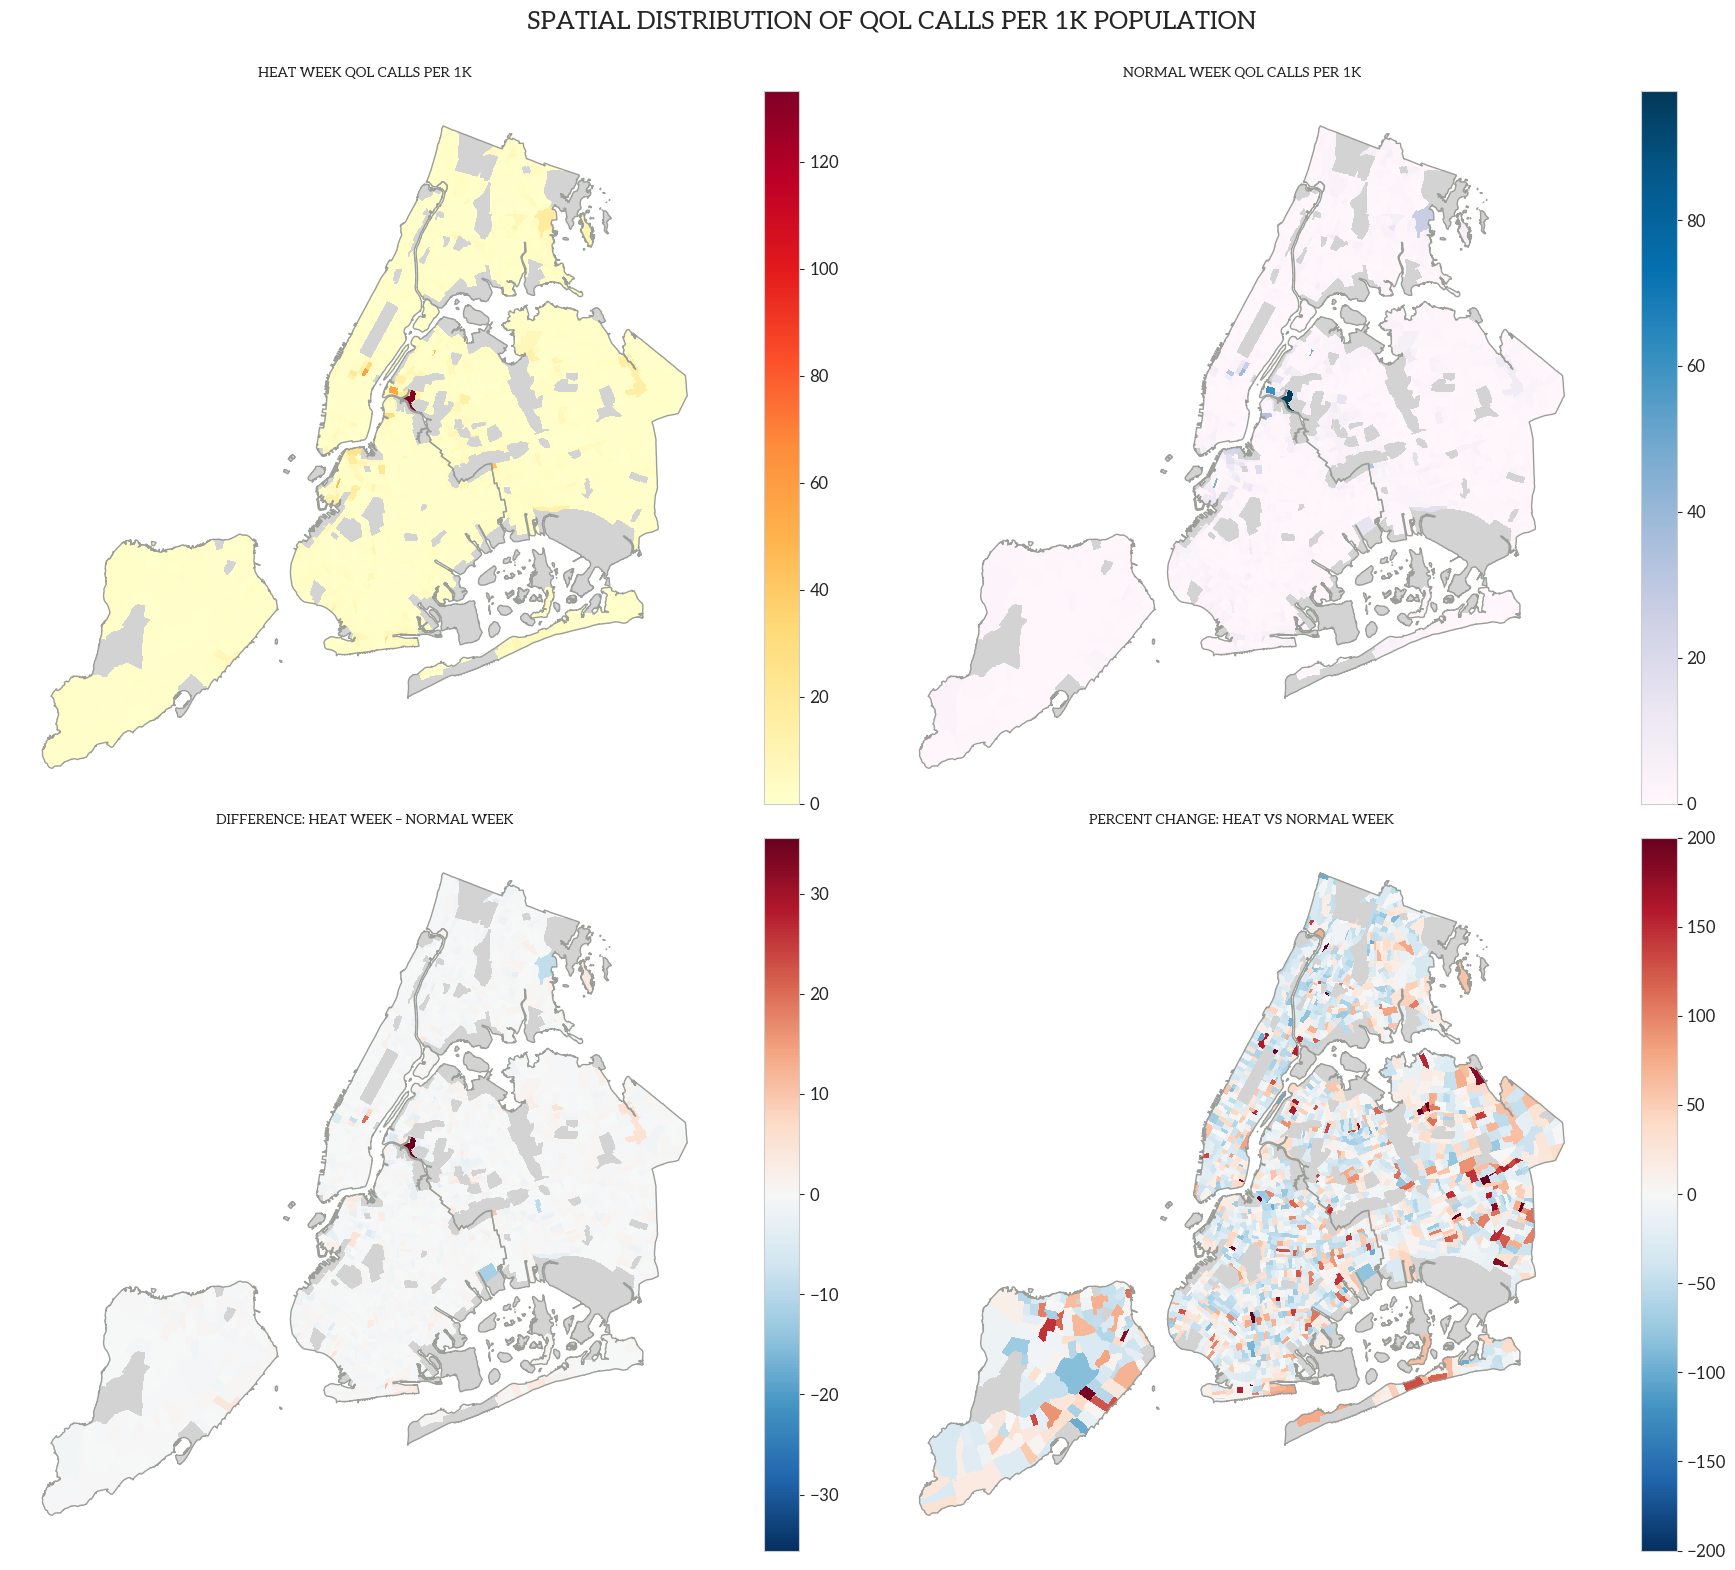

In [22]:
fig, axes = plt.subplots(2, 2, figsize = (18, 16))
fig.suptitle(
    "SPATIAL DISTRIBUTION OF QOL CALLS PER 1K POPULATION\n\n",
    fontsize = 18,
    fontweight = "bold"
)

# 1. Heat week calls.
plot_map(
    axes[0, 0],
    "heatweek_calls_per_1k",
    "YlOrRd",
    "HEAT WEEK QOL CALLS PER 1K",
    gdf
)

# 2. Normal week calls.
plot_map(
    axes[0, 1],
    "normalweek_calls_per_1k",
    "PuBu",
    "NORMAL WEEK QOL CALLS PER 1K",
    gdf
)

# 3. Difference (heat – normal).
gdf["calls_per_1k_diff"] = (
    gdf["heatweek_calls_per_1k"] - gdf["normalweek_calls_per_1k"]
)

diff = gdf["calls_per_1k_diff"]
max_abs = np.nanmax(np.abs(diff))

plot_map(
    axes[1, 0],
    "calls_per_1k_diff",
    "RdBu_r",
    "DIFFERENCE: HEAT WEEK – NORMAL WEEK",
    gdf,
    vmin = -max_abs,
    vmax = max_abs
)

# Percent change.
gdf["pct_change"] = (
    (gdf["heatweek_calls_per_1k"] - gdf["normalweek_calls_per_1k"])
    / gdf["normalweek_calls_per_1k"].replace(0, np.nan)
) * 100

pct = gdf["pct_change"].clip(-200, 200)
gdf["pct_change_clipped"] = pct

plot_map(
    axes[1, 1],
    "pct_change",
    "RdBu_r",
    "PERCENT CHANGE: HEAT VS NORMAL WEEK",
    gdf,
    vmin = -200,
    vmax = 200
)

plt.tight_layout()
plt.show()


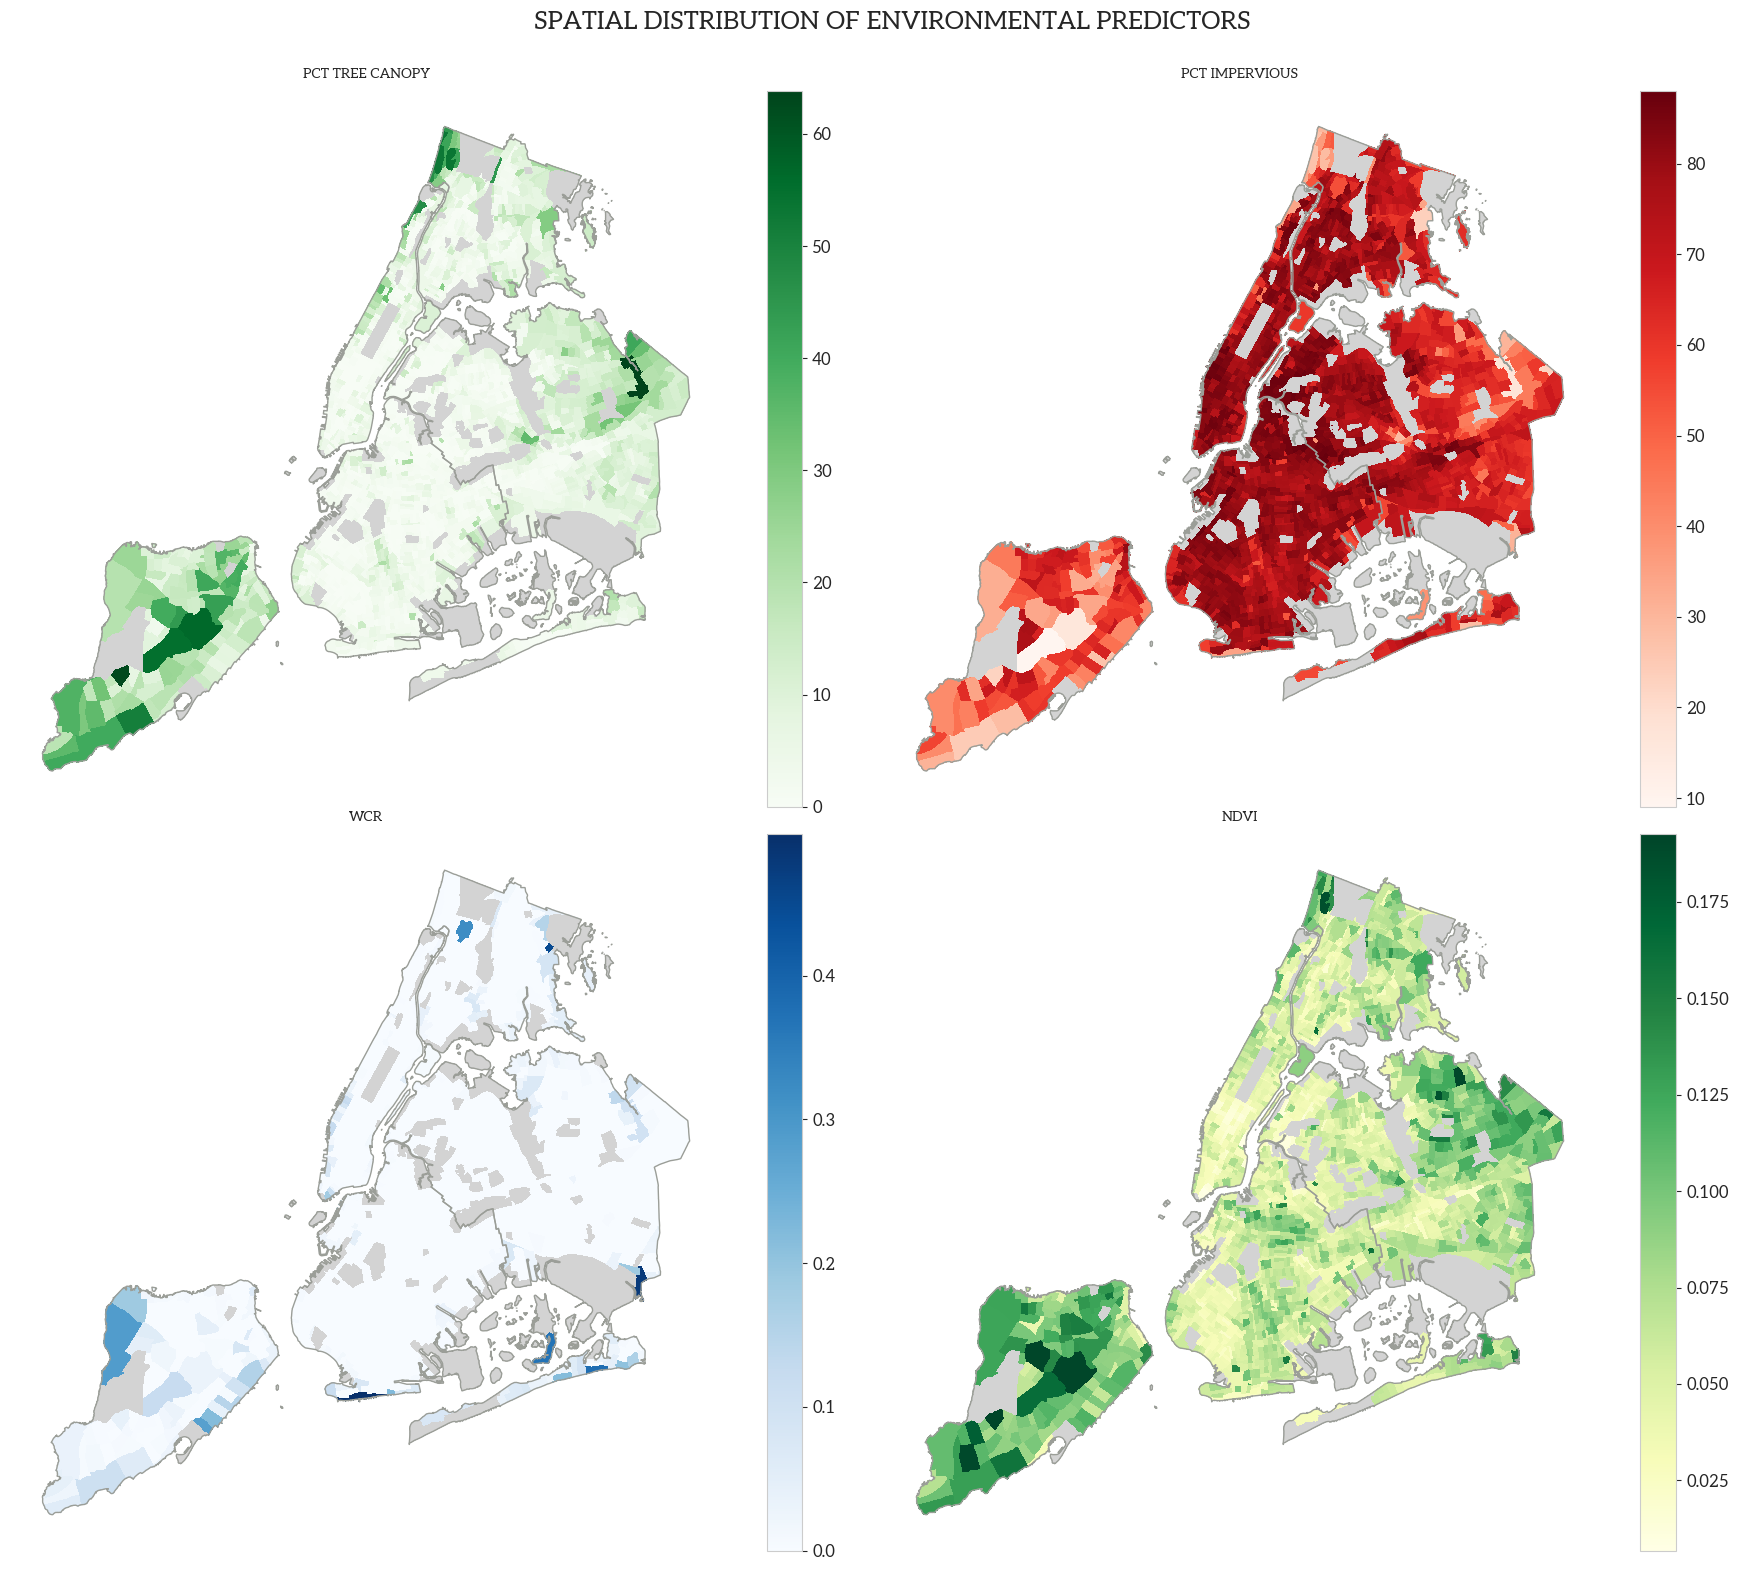

In [23]:
fig, axes = plt.subplots(2, 2, figsize = (18, 16))
fig.suptitle(
    "SPATIAL DISTRIBUTION OF ENVIRONMENTAL PREDICTORS\n\n",
    fontsize = 18,
    fontweight = "bold"
)

cmaps = ["Greens", "Reds", "Blues", "YlGn"]

for idx, (var, cmap) in enumerate(zip(env_predictors, cmaps)):
    row = idx // 2
    col = idx % 2
    
    title = var.replace("_", " ").upper()
    plot_map(axes[row, col], var, cmap, title, gdf)

plt.tight_layout()
plt.show()

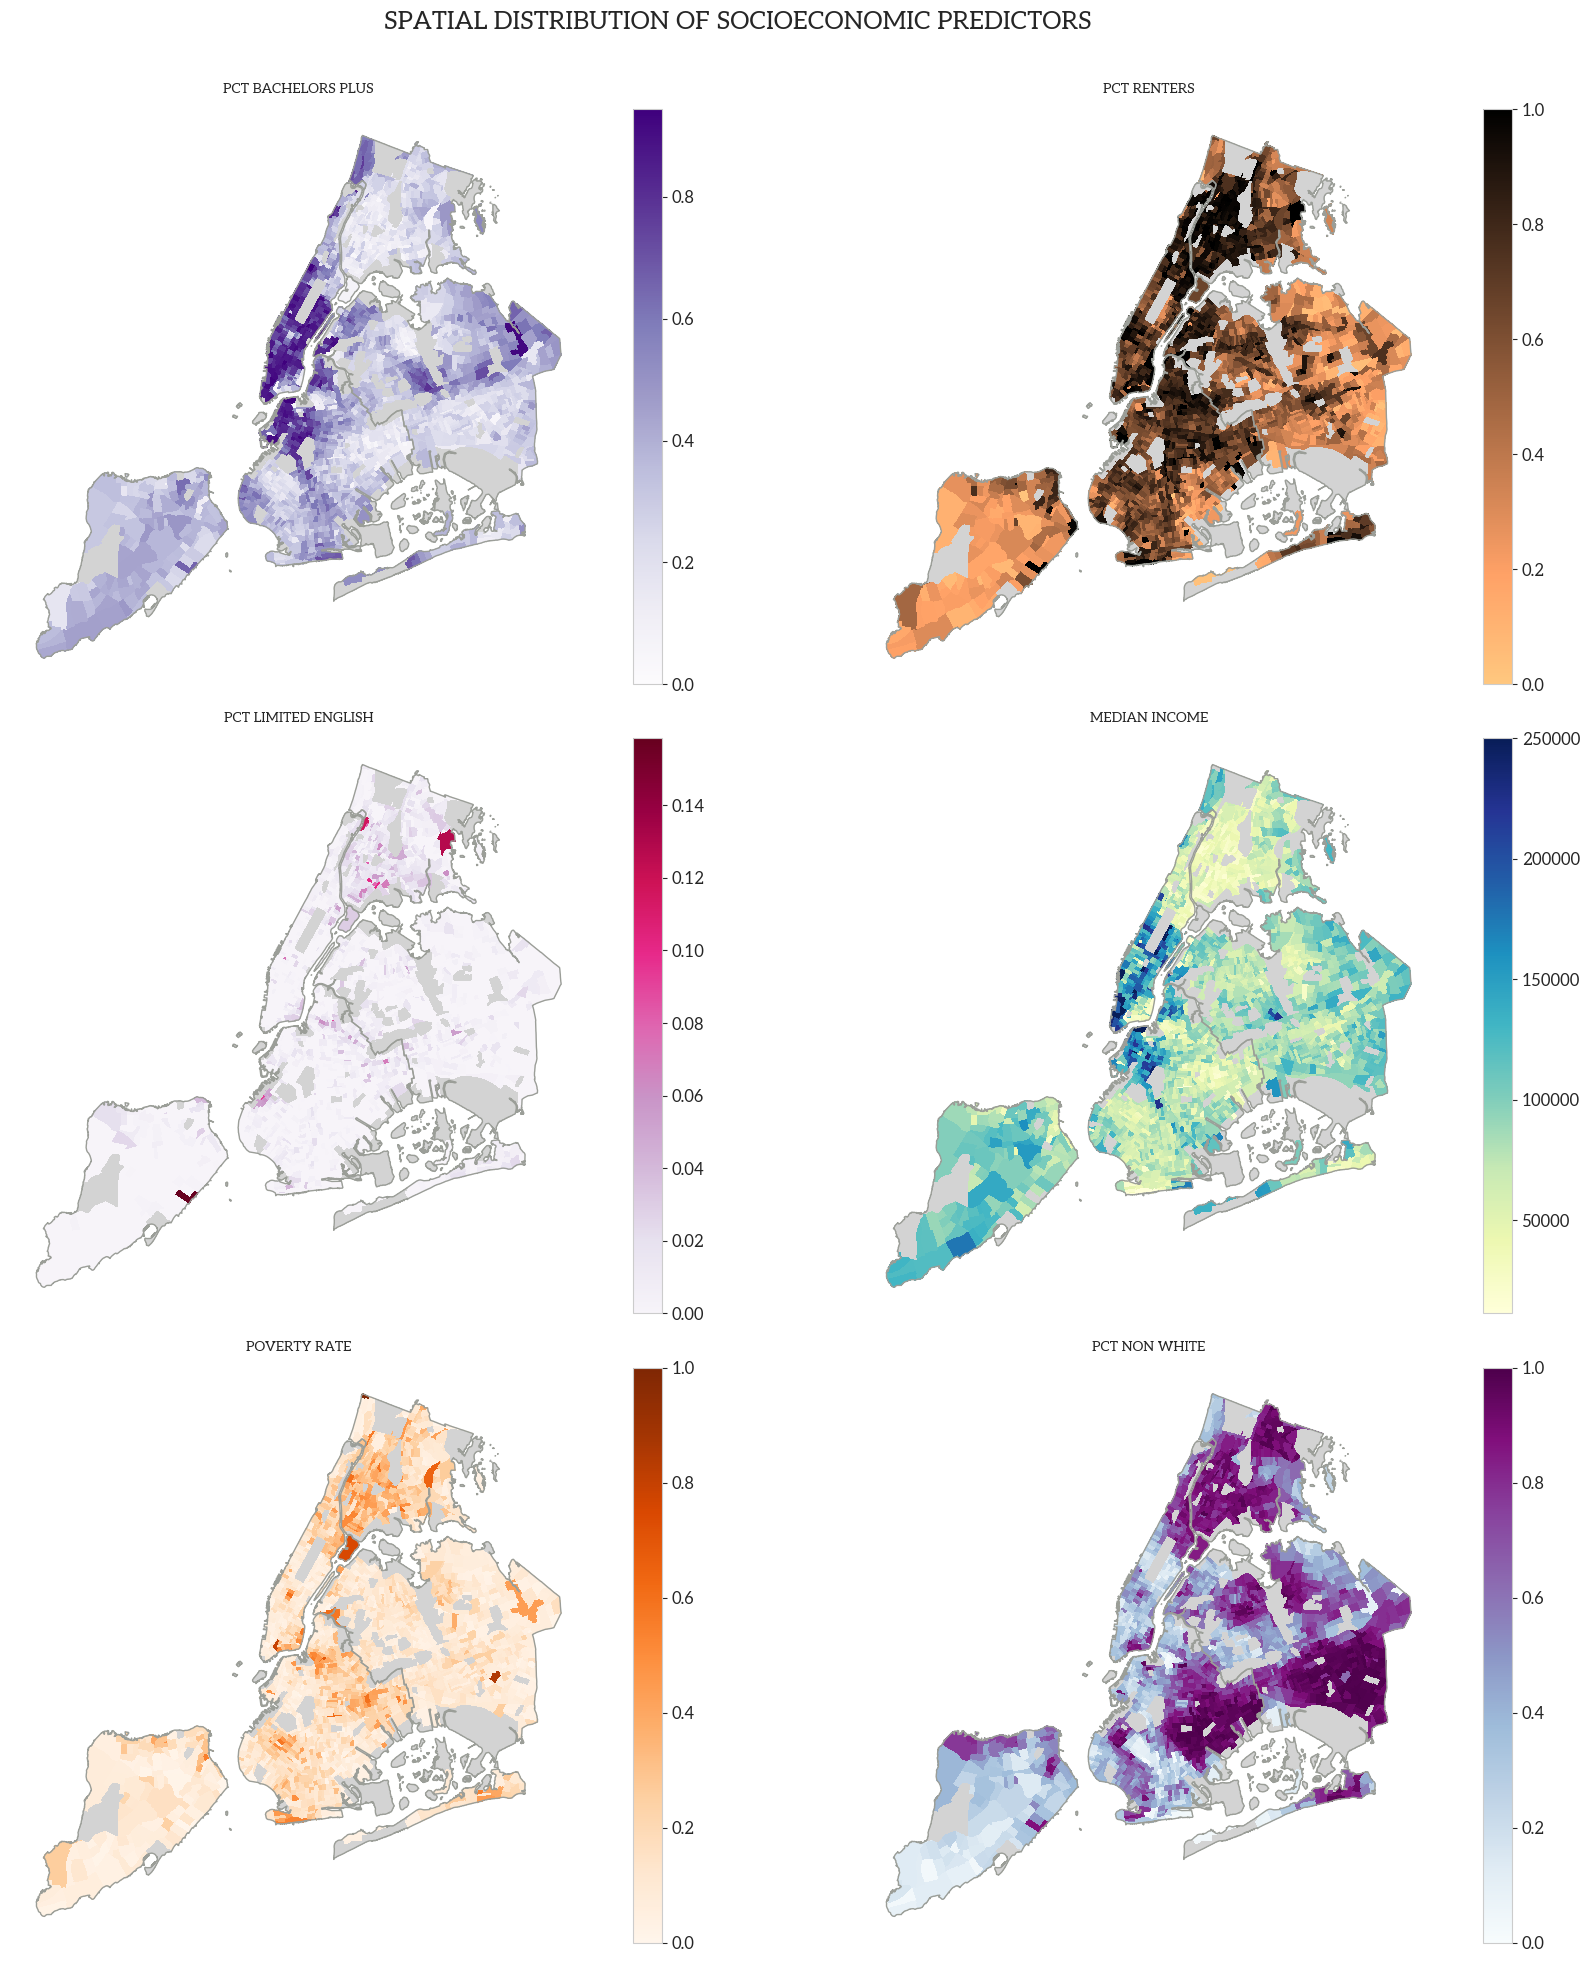

In [24]:
fig, axes = plt.subplots(3, 2, figsize = (18, 20))
fig.suptitle(
    "SPATIAL DISTRIBUTION OF SOCIOECONOMIC PREDICTORS\n\n",
    fontsize = 18,
    fontweight = "bold"
)

cmaps = ["Purples", "copper_r", "PuRd", "YlGnBu", "Oranges", "BuPu"]

for idx, (var, cmap) in enumerate(zip(acs_predictors, cmaps)):
    row = idx // 2
    col = idx % 2
    
    # Handle MEDIAN_INCOME.
    if var == "MEDIAN_INCOME":
        plot_gdf = gdf.copy()
        plot_gdf.loc[plot_gdf[var] < 0, var] = np.nan
    else:
        plot_gdf = gdf
    
    title = var.replace("_", " ").upper()
    plot_map(axes[row, col], var, cmap, title, plot_gdf)

plt.tight_layout()
plt.show()

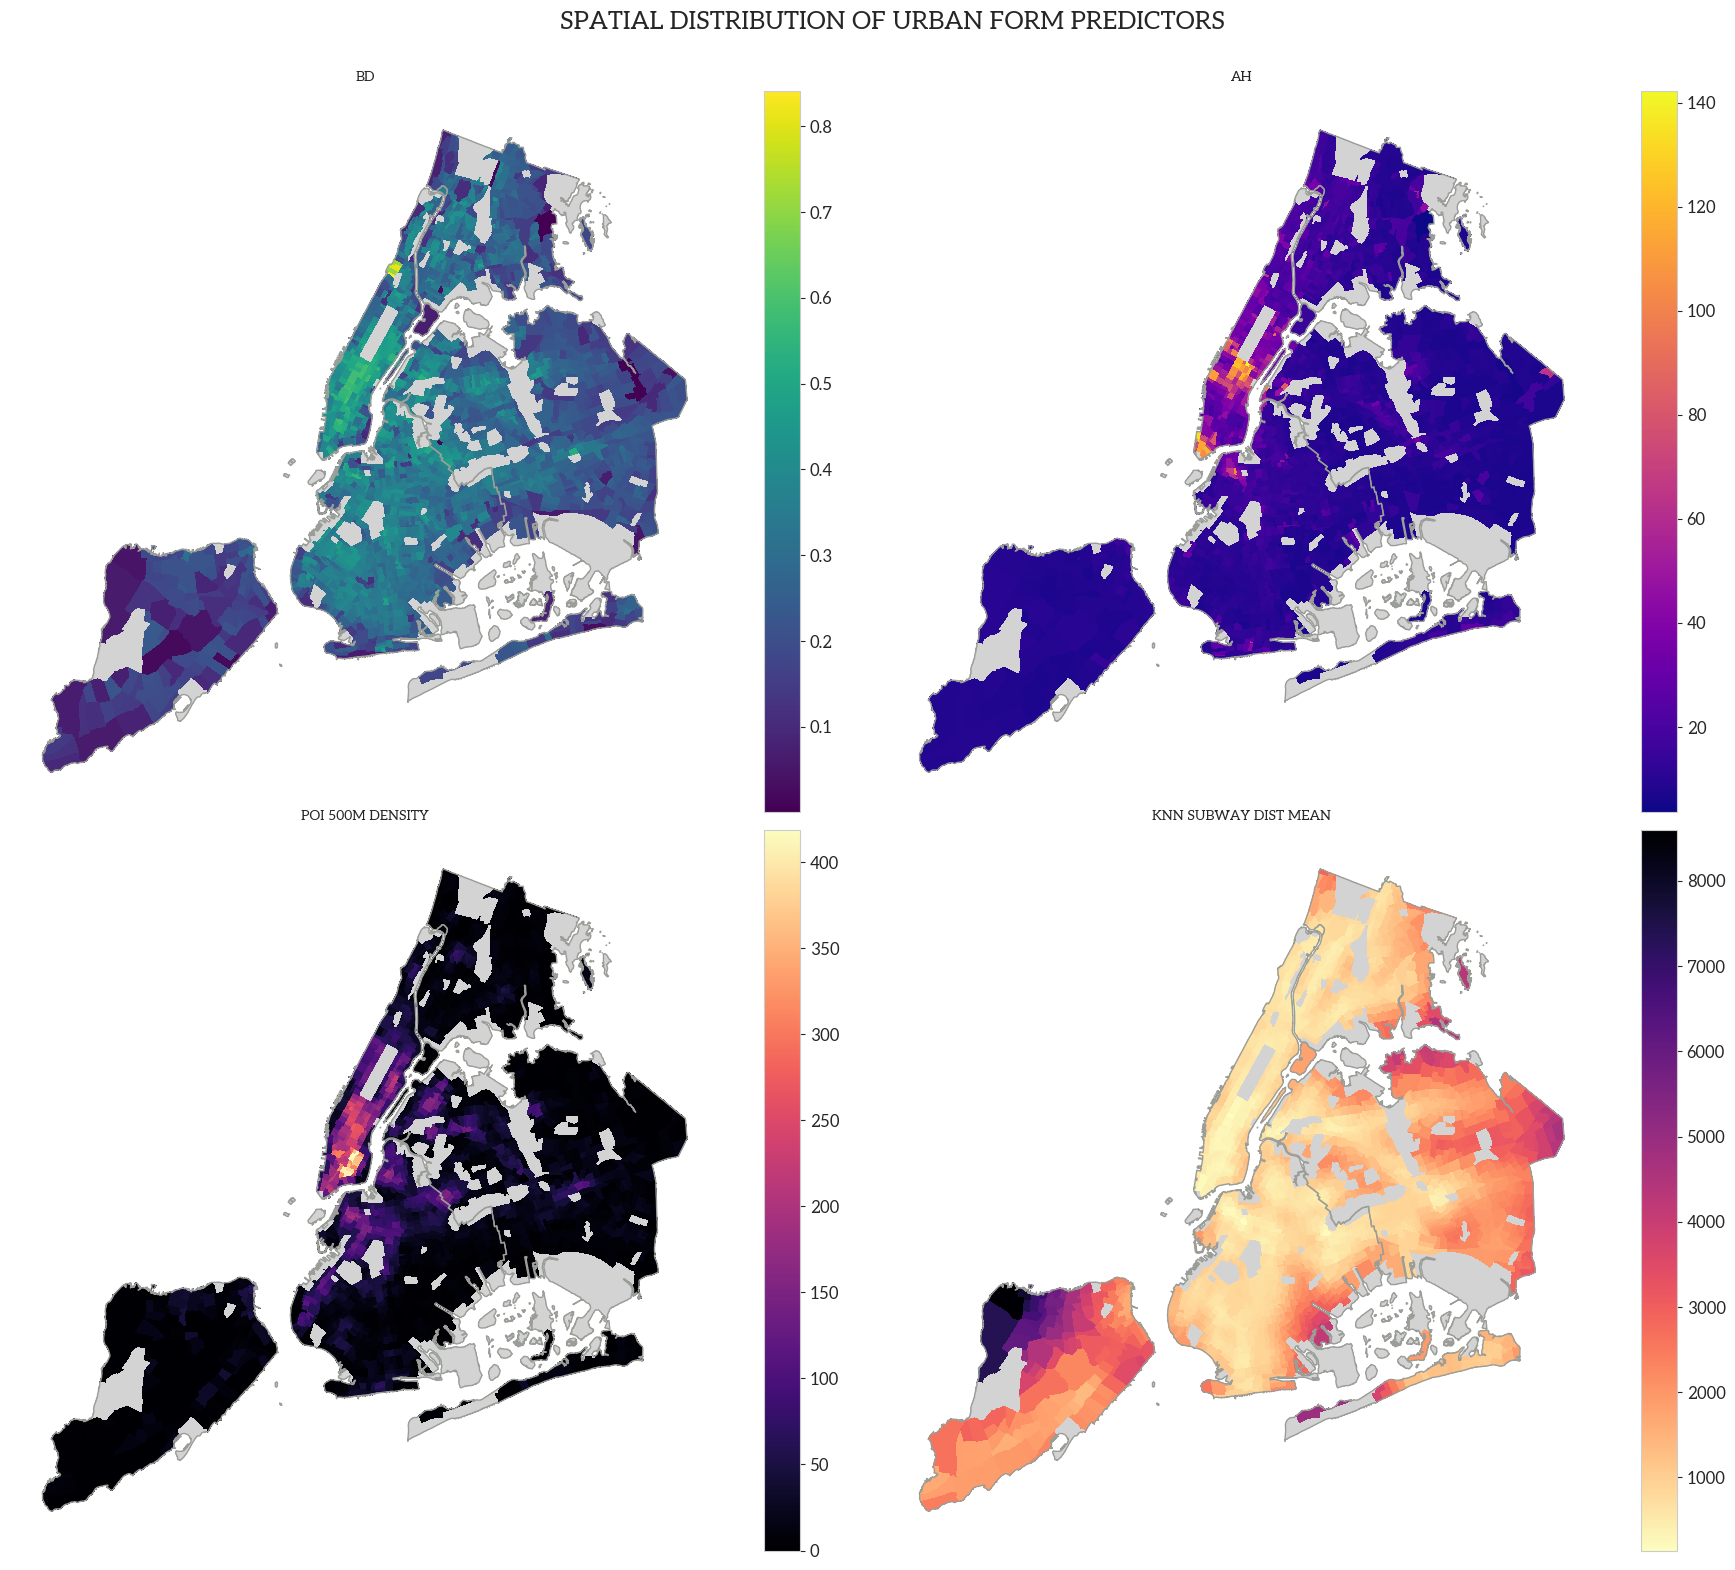

In [25]:
fig, axes = plt.subplots(2, 2, figsize = (18, 16))
fig.suptitle(
    "SPATIAL DISTRIBUTION OF URBAN FORM PREDICTORS\n\n",
    fontsize = 18,
    fontweight = "bold"
)

cmaps = ["viridis", "plasma", "magma", "magma_r"]

for idx, (var, cmap) in enumerate(zip(urban_predictors, cmaps)):
    row = idx // 2
    col = idx % 2
    
    title = var.replace("_", " ").upper()
    plot_map(axes[row, col], var, cmap, title, gdf)

plt.tight_layout()
plt.show()

**ANALYSIS: SPATIAL DISTRIBUTION PATTERNS**

The outliers significantly wash out the other tracts in NYC, many 311 super users are in the Queens Borough in the Long Island City area right around LaGuardia Community College. This general area looks like it has a higher non-white and higher poverty rate.

Most notably, the percent change map looks like it lacks spatial autocorrelation, but visually the impact must be influenced by some scattered tracts with low baseline activity that makes it look fragmented. This must indicate some kind of stress that's unique to the tracts and their mechanism shifts.

Despite the visual scattered perception, it does look like that the changes are more skewed toward peripheral edges of the boroughs.

Also, MEDIAN_INCOME and PCT_BACHELORS_PLUS show an almost inverse spatial pattern when compared to PCT_NON_WHITE.

#### 6.2 Spatial Autocorrelation Analysis

In [52]:
# Prepare spatial weights matrix using Queen contiguity.
# Remove tracts without data for spatial weights calculation.
gdf_complete = gdf.dropna(subset = ["heatweek_calls_per_1k"])
w = Queen.from_dataframe(gdf_complete)
w.transform = "r"  # Row-standardization.

# Calculate Moran's I for selected variables.
test_vars = targets + ["calls_per_1k_diff"] + env_predictors[:2] + acs_predictors[:2]
morans_results = []

for var in test_vars:
    if var in gdf_complete.columns and gdf_complete[var].notna().sum() > 0:
        try:
            mi = Moran(gdf_complete[var], w)
            morans_results.append({
                "Variable": var,
                "Moran's I": mi.I,
                "Expected I": mi.EI,
                "p-value": mi.p_sim,
                "Significant": "Yes" if mi.p_sim < 0.05 else "No"
            })
        except:
            continue

morans_df = pd.DataFrame(morans_results)
print(morans_df.to_string(index = False))

('WARNING: ', 815, ' is an island (no neighbors)')
('WARNING: ', 1635, ' is an island (no neighbors)')
('WARNING: ', 2036, ' is an island (no neighbors)')
               Variable  Moran's I  Expected I  p-value Significant
  heatweek_calls_per_1k       0.16       -0.00     0.00         Yes
normalweek_calls_per_1k       0.19       -0.00     0.00         Yes
        PCT_TREE_CANOPY       0.64       -0.00     0.00         Yes
         PCT_IMPERVIOUS       0.63       -0.00     0.00         Yes
     PCT_BACHELORS_PLUS       0.79       -0.00     0.00         Yes
            PCT_RENTERS       0.65       -0.00     0.00         Yes


Spatial weights created for 2,225 tracts.

Average number of neighbors: 5.87.

Moran's I ranges from -1 (dispersed) to +1 (clustered). Values near 0 indicate random spatial pattern.

Positive Moran's I indicates spatial clustering (similar values near each other).

Negative Moran's I indicates spatial dispersion (dissimilar values near each other).

p-value < 0.05 indicates statistically significant spatial pattern.


LISA Cluster Summary:
lisa_label
Not Significant    1750
LL (Low-Low)        323
HH (High-High)       87
LH (Low-High)        48
HL (High-Low)        17


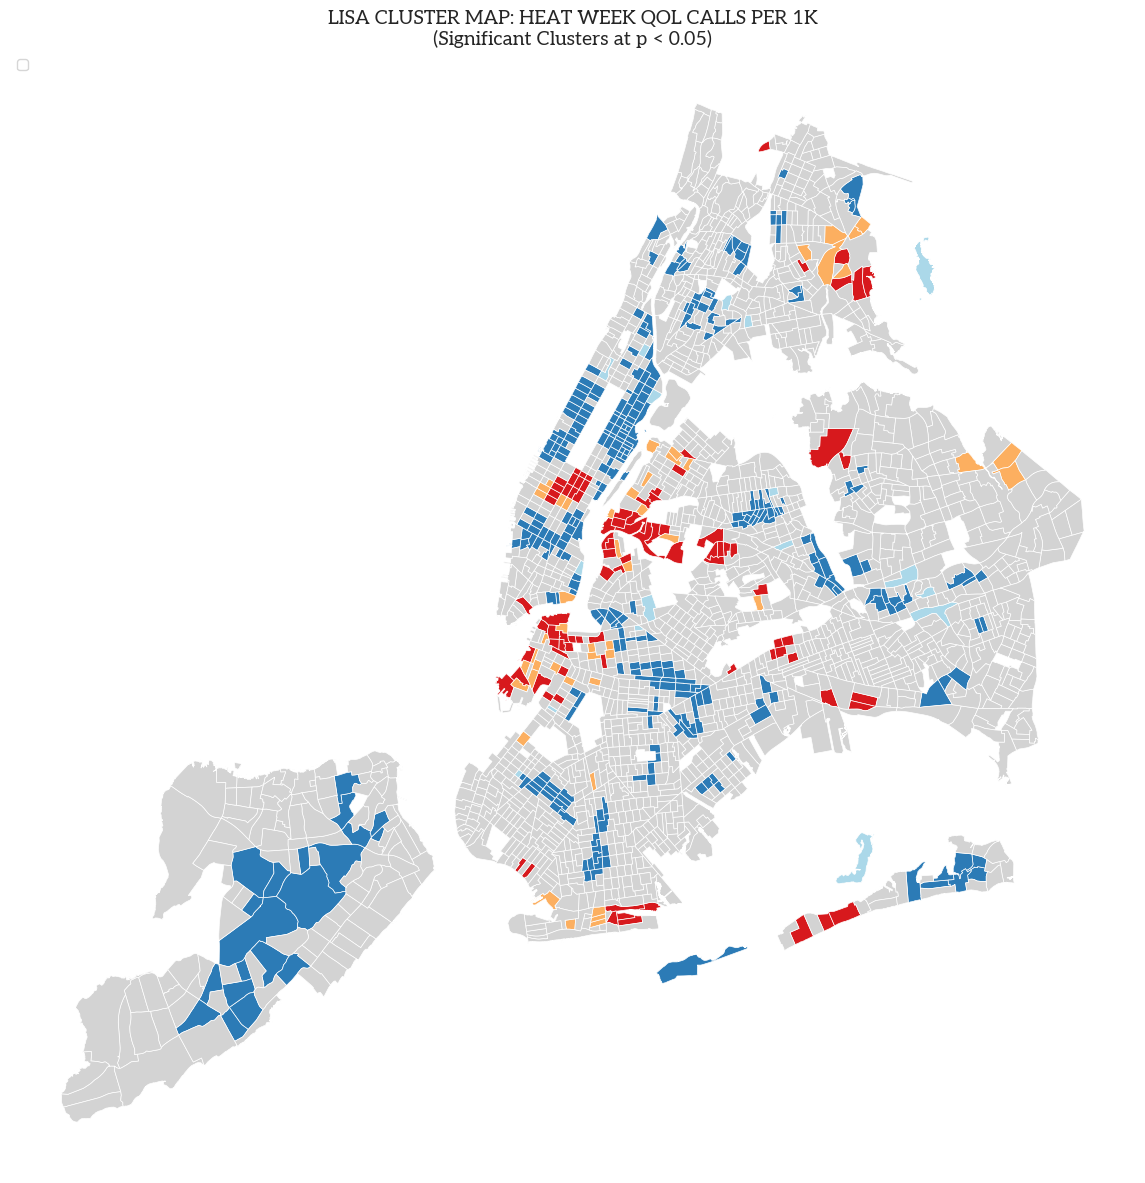

In [27]:
# Calculate Local Moran's I.
lisa = Moran_Local(gdf_complete["heatweek_calls_per_1k"], w)

# Add LISA results to geodataframe.
gdf_complete["lisa_cluster"] = lisa.q
gdf_complete["lisa_pval"] = lisa.p_sim
gdf_complete["lisa_sig"] = (lisa.p_sim < 0.05).astype(int)

# Create cluster labels.
cluster_labels = {
    1: "HH (High-High)",
    2: "LH (Low-High)",
    3: "LL (Low-Low)",
    4: "HL (High-Low)",
    0: "Not Significant"
}

# Filter for significant clusters only.
gdf_complete["lisa_label"] = gdf_complete.apply(
    lambda row: cluster_labels[row["lisa_cluster"]] if row["lisa_sig"] == 1 else cluster_labels[0],
    axis = 1
)

# Summary of clusters.
cluster_summary = gdf_complete["lisa_label"].value_counts()
print("\nLISA Cluster Summary:")
print(cluster_summary.to_string())

# Map LISA clusters.
fig, ax = plt.subplots(figsize = (14, 12))

# Define colors for clusters.
cluster_colors = {
    "HH (High-High)": "#d7191d",
    "LL (Low-Low)": "#2c7bb6",
    "LH (Low-High)": "#fcaf60",
    "HL (High-Low)": "#abd8e9",
    "Not Significant": "lightgray"
}

for label, color in cluster_colors.items():
    subset = gdf_complete[gdf_complete["lisa_label"] == label]
    if len(subset) > 0:
        subset.plot(ax = ax, color = color, edgecolor = "white", linewidth = 0.5, label = label)

ax.set_title("LISA CLUSTER MAP: HEAT WEEK QOL CALLS PER 1K\n(Significant Clusters at p < 0.05)", 
             fontsize = 14, fontweight = "bold")
ax.axis("off")
ax.legend(loc = "upper left", fontsize = 10)

plt.tight_layout()
plt.show()

**ANALYSIS: LOCAL SPATIAL AUTOCORRELATION - LISA CLUSTERS**

Positive and statistically significant Global Moran's I confirms heat week QoL calls exhibit spatial clustering rather than random geographic distribution. Positive spatial autocorrelation indicates high-call tracts tend to neighbor other high-call tracts, and low-call tracts cluster near other low-call areas.

**High-High Clusters (Red - Hot Spots):**
Statistically significant concentrations of high heat-week complaint activity include Manhattan Midtown / Downtown, central Brooklyn, and northwestern Queens.

**Low-Low Clusters (Blue - Cold Spots):**
Significant clusters of low complaint activity may represent outer borough residential areas with lower density and more green space, or areas with under-reporting due to language barriers or socioeconomic factors affecting 311 engagement. Different factors are varying, and may include better environmental conditions and less vulnerability; under-reporting due to language barriers, distrust of government, alternative coping strategies, etc.; and perhaps heat-related needs are expressed through non-311 channels.

**Spatial Outliers (Light Blue / Pink):**
Low-High and High-Low outliers represent tracts with complaint patterns diverging from their neighbors. These merit case-by-case investigation to understand protective or risk factors operating at micro-scale.

This has implications for OLS modeling, as positive spatial autocorrelation can inflate Type I error rates. This means standard OLS standard errors may be too small and lead to false significance claims.

Politically, LISA clusters identify geographic priorities for potential intervention and further investigation. Hot spots warrant immediate attention, though strategy should differ based on underlying causes and neighborhood idiosyncracies. Spatial clustering could suggest that interventions may generate positive externalities with cooling one tract potentially benefitting neighbors through some spillover aspects.

#### 6.3 Bivariate Choropleth Maps
For top predictors.

Code template adjusted from [Jeff Allen](https://schoolofcities.github.io/urban-data-storytelling/urban-data-visualization/bivariate-choropleth-maps/bivariate-choropleth-maps.html) at the University of Toronto's School of Cities.

In [28]:
# Function to create bivariate choropleth map.
def create_bivariate_map(gdf, var1, var2, title, var1_label, var2_label):
    """
    Create bivariate choropleth map showing relationship between two variables.
    
    Parameters:
    - gdf: GeoDataFrame with spatial data.
    - var1: First variable name (string).
    - var2: Second variable name (string).
    - title: Map title (string).
    - var1_label: Label for first variable (string).
    - var2_label: Label for second variable (string).
    """
    
    # Create copy and remove missing values.
    plot_gdf = gdf[[var1, var2, "geometry"]].copy().dropna()
    
    # Classify each variable into 3 quantiles.
    plot_gdf[f"{var1}_class"] = pd.qcut(plot_gdf[var1], q = 3, labels = ["Low", "Med", "High"], duplicates = "drop")
    plot_gdf[f"{var2}_class"] = pd.qcut(plot_gdf[var2], q = 3, labels = ["Low", "Med", "High"], duplicates = "drop")
    
    # Create bivariate class.
    plot_gdf["bivar_class"] = plot_gdf[f"{var1}_class"].astype(str) + "-" + plot_gdf[f"{var2}_class"].astype(str)
    
    # Define color scheme for 3x3 bivariate map.
    color_dict = {
        "Low-Low": "#e8e8e8",
        "Low-Med": "#ace4e4",
        "Low-High": "#5ac8c8",
        "Med-Low": "#dfb0d6",
        "Med-Med": "#a5add3",
        "Med-High": "#5698b9",
        "High-Low": "#be64ac",
        "High-Med": "#8c62aa",
        "High-High": "#3b4994"
    }
    
    # Map colors.
    plot_gdf["color"] = plot_gdf["bivar_class"].map(color_dict)
    
    # Create plot.
    fig, ax = plt.subplots(figsize = (14, 12))

    plot_gdf.plot(color = plot_gdf["color"], ax = ax, edgecolor = "white", linewidth = 0.5)

    ax.set_title(title, fontsize = 14, fontweight = "bold")

    ax.axis("off")
    
    legend_elements = []

    for key, color in color_dict.items():
        legend_elements.append(Rectangle((0, 0), 1, 1, facecolor = color, edgecolor = "none", label = key))
    
    ax.legend(handles = legend_elements, title = f"{var1_label} - {var2_label}", 
              loc = "upper left", fontsize = 8, ncol = 3)
    
    plt.tight_layout()
    plt.show()
    
    return plot_gdf

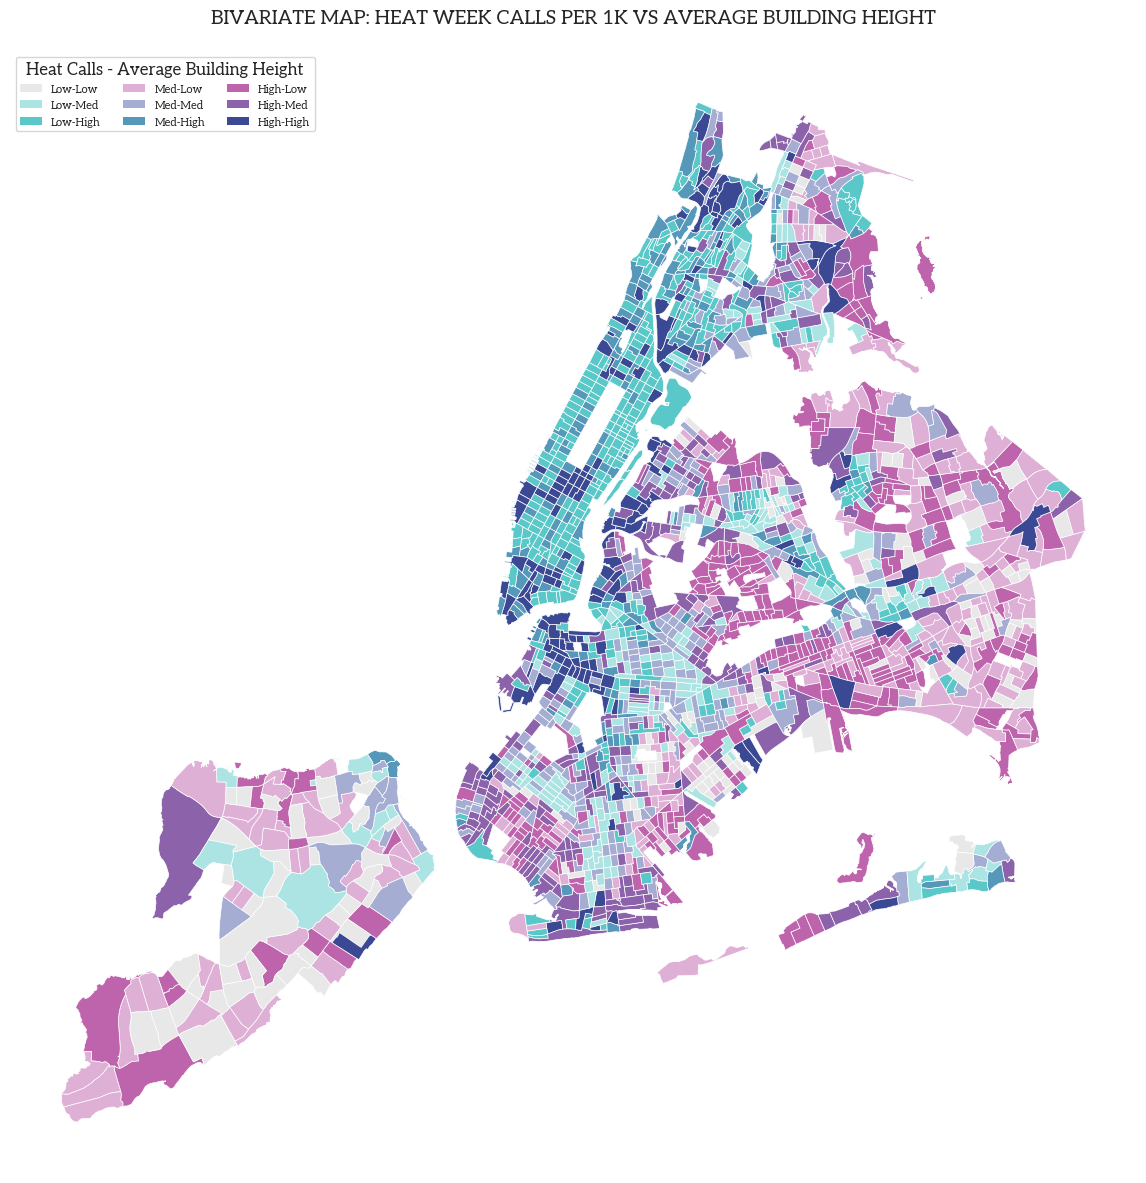

In [53]:
# Heat Week Calls vs Average Building Height.
bivar_heat_AH = create_bivariate_map(
    gdf,
    "heatweek_calls_per_1k",
    "AH",
    "BIVARIATE MAP: HEAT WEEK CALLS PER 1K VS AVERAGE BUILDING HEIGHT\n",
    "Heat Calls",
    "Average Building Height"
)

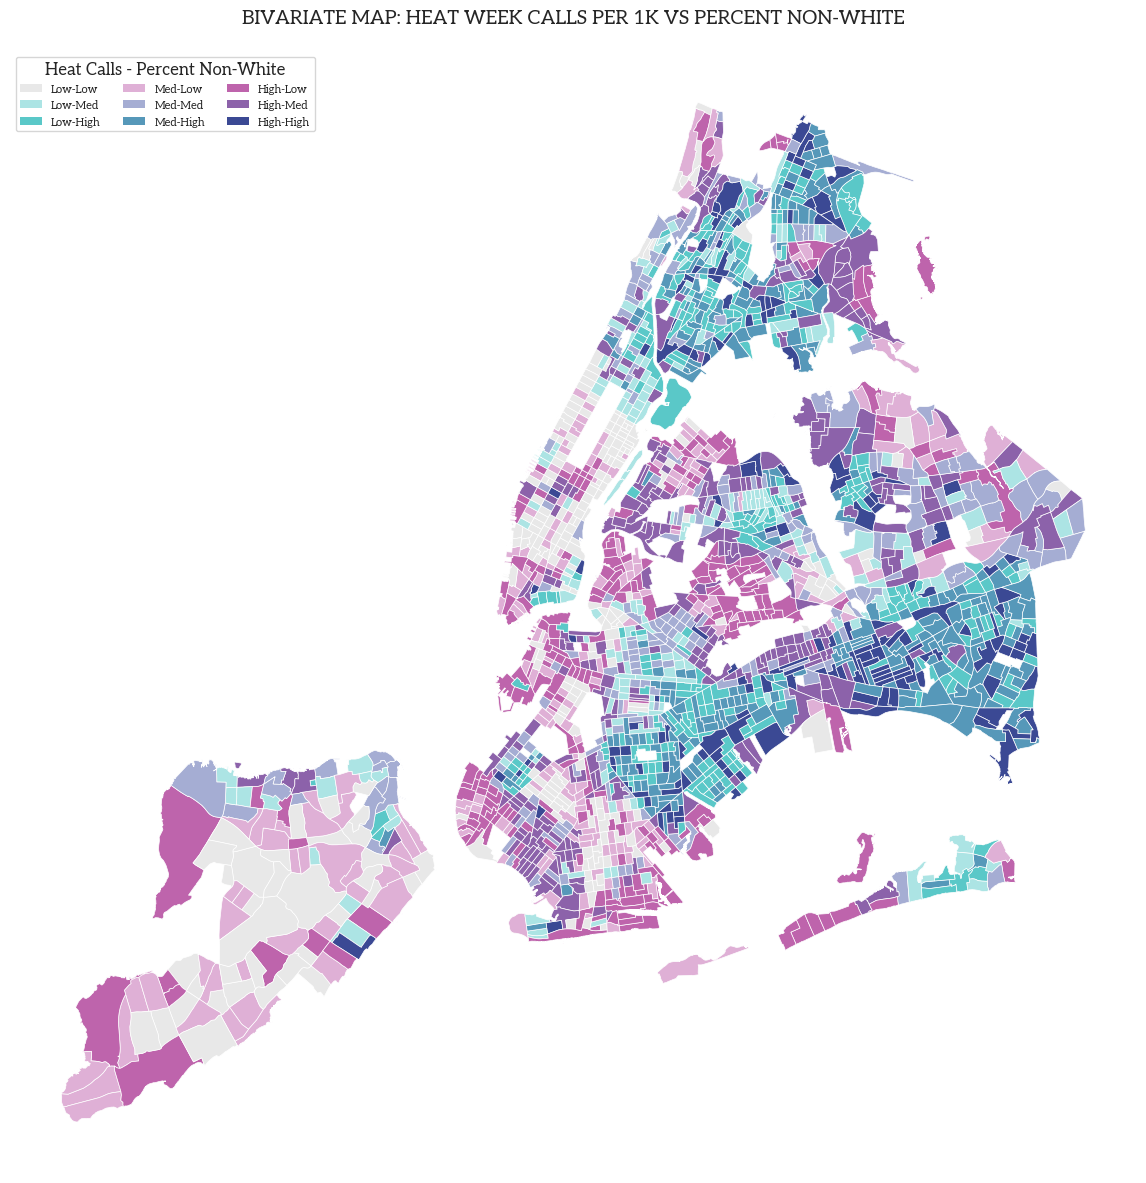

In [54]:
# Heat Week Calls vs Percent Non-White.
bivar_heat_NON_WHITE = create_bivariate_map(
    gdf,
    "heatweek_calls_per_1k",
    "PCT_NON_WHITE",
    "BIVARIATE MAP: HEAT WEEK CALLS PER 1K VS PERCENT NON-WHITE\n",
    "Heat Calls",
    "Percent Non-White"
)

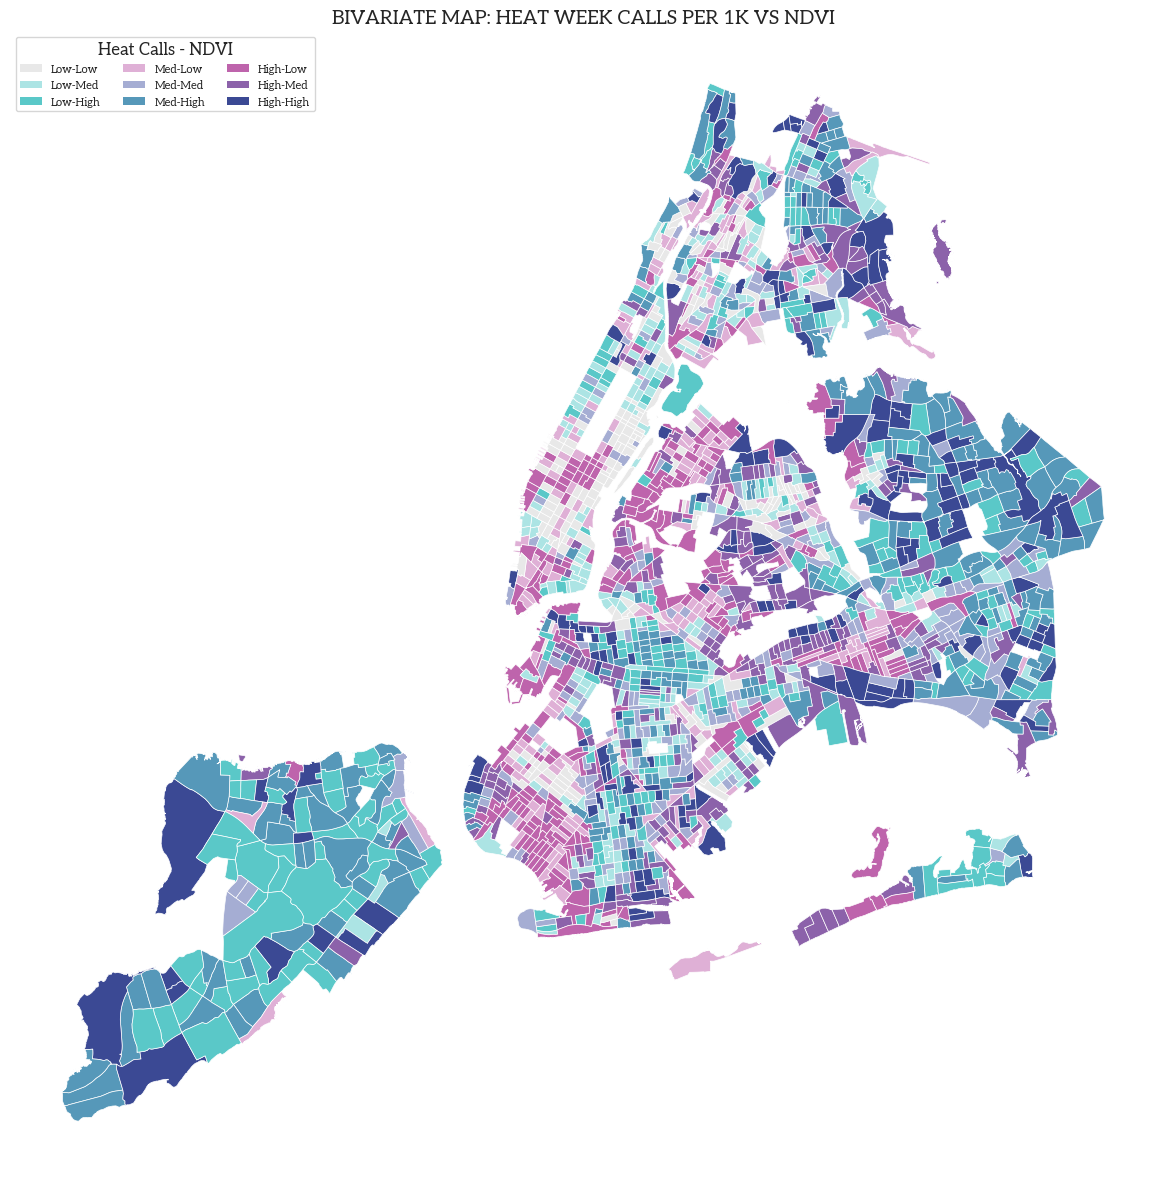

In [55]:
# Heat Week Calls vs NDVI.
bivar_heat_NDVI = create_bivariate_map(
    gdf,
    "heatweek_calls_per_1k",
    "NDVI",
    "BIVARIATE MAP: HEAT WEEK CALLS PER 1K VS NDVI",
    "Heat Calls",
    "NDVI"
)

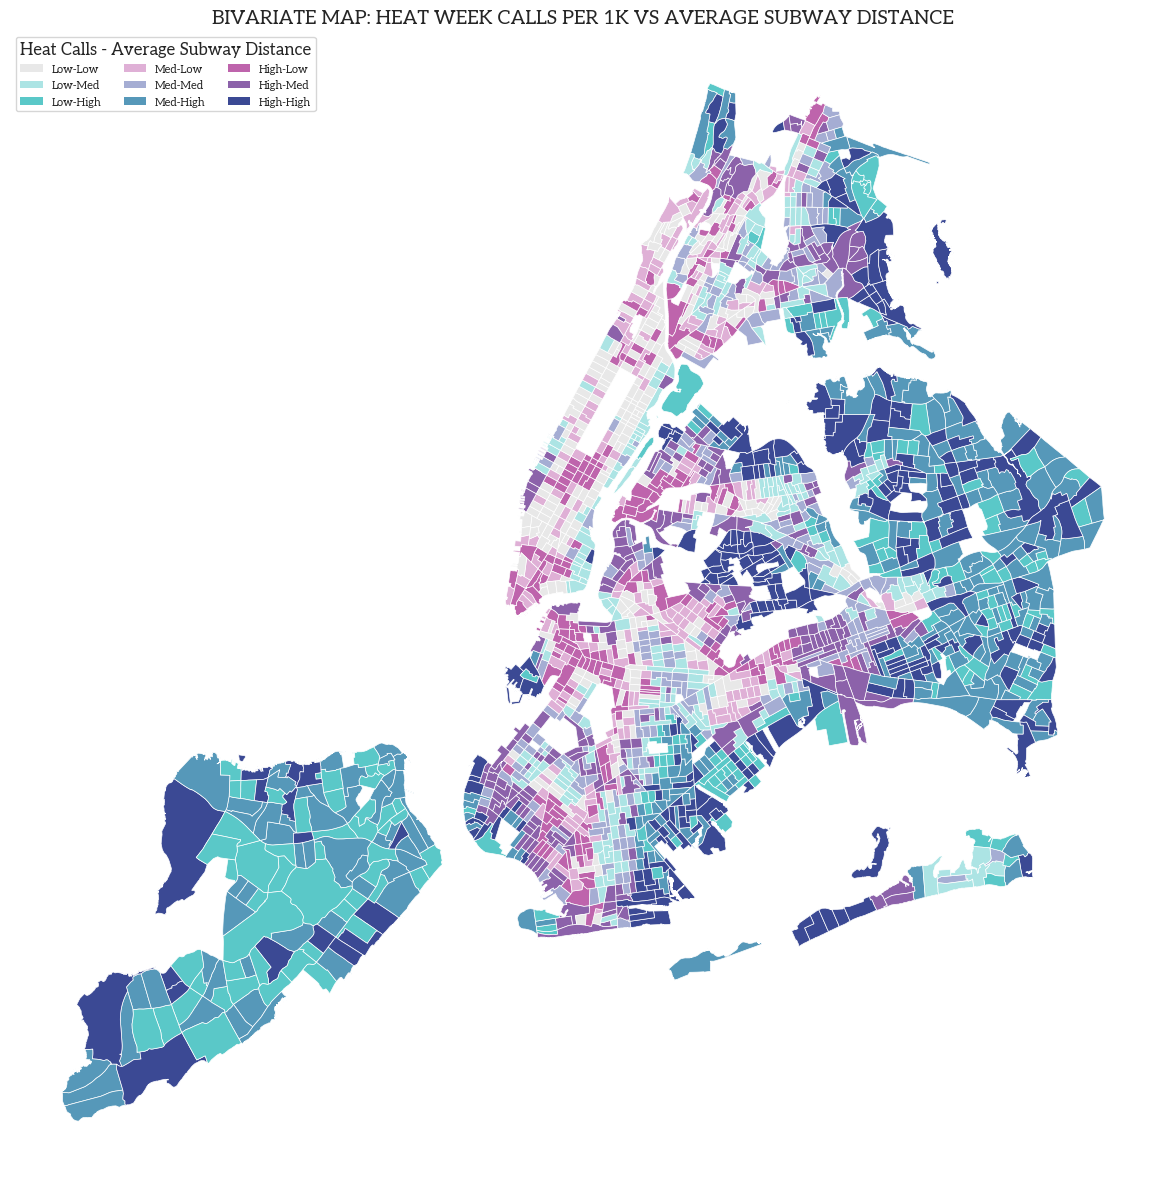

In [56]:
# Bivariate map: Heat week calls vs Subway distance.
bivar_heat_SUBWAY = create_bivariate_map(
    gdf,
    "heatweek_calls_per_1k",
    "KNN_SUBWAY_dist_mean",
    "BIVARIATE MAP: HEAT WEEK CALLS PER 1K VS AVERAGE SUBWAY DISTANCE",
    "Heat Calls",
    "Average Subway Distance"
)

The bivariate choropleth maps collectively demonstrate that QoL vulnerability during extreme heat is not determined by a single environmental or socioeconomic factor, but by the conditional interaction of the built environment and resident resources. There are many expected patterns, but there are also contradictions.

AH and NDVI showed that a "favorable" (people generally prefer more space and greenery) environmental structure does not guarantee resilience. Tracts with high AH and high NDVI often had low QoL calls, so high socioeconomic status and quality infrastructure do decouple and insulate residents from environmental stress. However, tracts with high NDVI but high complaint rates suggest that the protective green buffer fails when housing quality is poor or social vulnerability is high, which is unsurprising.

The percent non-white map reflects the dilemma of under-reporting in vulnerable yet low-complaint tracts, providing an environmental justice lens to this finding. Then the average subway distance map showed that it' i's a complex proxy as close subway proximity drives high complaint activity due to density, but farther subway locations also generate high complaints, overlapping with socioeconomic isolation and limited access to critical services.

All of this is why non-linear models like Random Forest and SHAP are needed to capture these urban complexities and interactions.